In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [6]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [7]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [8]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [197]:
datapoint_per_second = 20
duration = 2
chunk_size = 7
seq_len = 21
classes = {0: 'target', 1: 'front_pocket', 2: 'pocket', 3: 'swing'}

In [10]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [11]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [12]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

388 370 364


In [13]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.46666997e+00,  3.02090550e-02,  1.02965024e+00, -4.78252917e-01,
        -3.82730037e-01,  1.22318631e-02,  8.28334045e+00, -1.33542404e+01,
         4.17045288e+01,  1.67575811e+09]),
 array([ 1.25826234e-01, -1.58992693e+00, -1.53935553e+00, -6.28472567e-02,
         3.16822752e-02,  2.58390278e-01, -3.71943283e+01,  1.32483292e+00,
        -2.49790649e+01,  1.67575811e+09]))

# 建立dataloader

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [15]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.8)
pocket_half = int(len(pocket_pair_data) * 0.8)
swing_half = int(len(swing_pair_data) * 0.8)

train_data = front_pocket_pair_data[:front_pocket_half] + pocket_pair_data[:pocket_half] + swing_pair_data[:swing_half]
valid_data = front_pocket_pair_data[front_pocket_half:] + pocket_pair_data[pocket_half:] + swing_pair_data[swing_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=256)

In [18]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [19]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    
class My_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, num_layers, batch_first, bidirectional):
        super(My_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.rnn  = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
        self.rnn2 = nn.GRU(input_size=hidden_size, hidden_size=out_size, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
    def forward(self, input_seq):
        output, _ = self.rnn(input_seq)
#         output = (output[:,:,:self.hidden_size] + output[:,:,:self.hidden_size]) / 2
        output, _ = self.rnn2(output)
#         output = (output[:,:,:self.out_size] + output[:,:,:self.out_size]) / 2
        return output

class Feature_extract(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, num_layers, batch_first, bidirectional, chunk_size=5, seq_len=21):
        super(Feature_extract, self).__init__()
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.rnn = My_RNN(input_size=input_size* self.seq_len, hidden_size=hidden_size* self.seq_len, out_size=out_size* self.seq_len, num_layers=num_layers, batch_first=batch_first, bidirectional=bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, out_size),
            nn.LeakyReLU(),
        )
    def forward(self, input_seq):
        fc = self.fc(input_seq)
        r_seq = input_seq.reshape((len(input_seq), self.chunk_size, -1))
        rnn = self.rnn(r_seq)
        fc = fc.reshape((len(input_seq), self.chunk_size, -1))
        output = torch.add(fc, rnn)
        return output

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = Feature_extract(input_size=6, hidden_size=32, out_size=64, num_layers=1, batch_first=True, bidirectional=False, chunk_size=self.chunk_size, seq_len=self.seq_len)
        self.mag_layer = Feature_extract(input_size=3, hidden_size=16, out_size=64, num_layers=1, batch_first=True, bidirectional=False, chunk_size=self.chunk_size, seq_len=self.seq_len)
#         self.imu_layer = nn.Sequential(
#             nn.Linear(6, 32),
#             nn.LeakyReLU(),
#             nn.Linear(32, 64),
#             nn.LeakyReLU(),
#         )
#         self.imu_layer = My_RNN(input_size=6 * self.seq_len, hidden_size=32* self.seq_len, out_size=64* self.seq_len, num_layers=1, batch_first=True, bidirectional=False)
#         self.mag_layer = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 64),
#             nn.LeakyReLU(),
#         )
#         self.mag_layer = My_RNN(input_size=3 * self.seq_len, hidden_size=16* self.seq_len, out_size=64* self.seq_len, num_layers=1, batch_first=True, bidirectional=False)
        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.nn = My_RNN(input_size=64 * self.seq_len, hidden_size=32* self.seq_len, out_size=6 * self.seq_len, num_layers=1, batch_first=True, bidirectional=False)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
#         self.rnn = nn.RNN(input_size=64 * self.seq_len, hidden_size=3 * self.seq_len, num_layers=1, batch_first=True)
#         self.rnn = My_RNN(input_size=64 * self.seq_len, hidden_size=16* self.seq_len, out_size=3 * self.seq_len, num_layers=1, batch_first=True, bidirectional=False)
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
            nn.LeakyReLU(),
        )
#         self.mag_last = My_RNN(input_size=64 * self.seq_len, hidden_size=16* self.seq_len, out_size=3* self.seq_len, num_layers=2, batch_first=True, bidirectional=False)
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = source_imu
        
#         h_imu = h_imu.reshape((len(source_imu), self.chunk_size, -1))
        h_imu = self.imu_layer(h_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = source_mag

#         h_mag = h_mag.reshape((len(source_mag), self.chunk_size, -1))
        h_mag = self.mag_layer(h_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = z.reshape((len(source_imu), self.chunk_size, self.seq_len, -1))
        z_imu = self.nn(z_imu)
        
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = pred_latent.reshape((len(source_mag), self.chunk_size, self.seq_len, -1))
        pred_mag = self.mag_last(pred_mag)
        
#         pred_mag = self.mag_last(pred_mag)
        
        return z_imu, pred_mag
        

In [20]:
def output_class_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :9]
            source_mag = source_data[:, :, :, 9:12]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :9]
            target_mag = target_data[:, :, :, 9:12]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # record
            error = predict_mag.detach().cpu().numpy() - target_data[:, :, :, 9:12].cpu().numpy()
            error = np.mean(np.mean(np.mean(error, axis=-1), axis=-1), axis=-1)
            results.extend(zip(error, source_label.cpu().numpy()))
            
            break
    
    return np.array(results)

In [21]:
def output_class_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :9]
            source_mag = source_data[:, :, :, 9:12]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :9]
            target_mag = target_data[:, :, :, 9:12]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # record
            error = predict_mag.detach().cpu().numpy() - target_data[:, :, :, 9:12].cpu().numpy()
            error = np.mean(np.mean(np.mean(error, axis=-1), axis=-1), axis=-1)
            results.extend(zip(error, source_label.cpu().numpy()))
            
            break
    
    return np.array(results)

In [22]:
# class Discriminator(nn.Module):
#     def __init__(self, chunk_size=5, seq_len=21):
#         super(Discriminator, self).__init__()
        
#         self.chunk_size = chunk_size
#         self.seq_len = seq_len
        
#         self.feature_extractor = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
#         self.lstm = nn.LSTM(input_size=32 * self.seq_len, hidden_size=32 * self.seq_len, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.discriminant_layer = nn.Sequential(
#             nn.Linear(64 * self.seq_len, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 1),
#             nn.Sigmoid(),
#         )
        
#     def forward(self, x):
#         h = self.feature_extractor(x)  # (bs, chunk_size, seq_len, 3) -> (bs, chunk_size, seq_len, 16)
        
#         h = h.reshape((len(x), self.chunk_size, -1))  # (bs, chunk_size, seq_len, 16) -> (bs, chunk_size, seq_len * 16)
#         hz, _ = self.lstm(h)  # (bs, chunk_size, seq_len * 16) -> (bs, chunk_size, seq_len * 16 * 2)
        
#         out = self.discriminant_layer(hz)
        
#         return out

In [23]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)

    total_loss = imu_loss + mag_loss
    return total_loss, imu_loss, mag_loss

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [24]:
batch = next(iter(train_loader))

In [25]:
#batch.shape()
torch.__version__

'1.11.0+cu113'

In [26]:
EPOCH = 6000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()

In [27]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [28]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [29]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, :, :6]
        source_mag = source_data[:, :, :, 6:9]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, :, :6]
        target_mag = target_data[:, :, :, 6:9]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses)

In [30]:
def output_class_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # record
            error = predict_mag.detach().cpu().numpy() - target_data[:, :, :, 9:12].cpu().numpy()
            error = np.mean(np.mean(np.mean(error, axis=-1), axis=-1), axis=-1)
            results.extend(zip(error, source_label.cpu().numpy()))
            
            break
    
    return np.array(results)

In [31]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses)

In [32]:
from torchinfo import summary
summary(model, input_size=[(2, 7, 21, 6), (2, 7, 21, 3)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [2, 7, 21, 6]             --
├─Feature_extract: 1-1                        [2, 7, 1344]              --
│    └─Sequential: 2-1                        [2, 7, 21, 64]            --
│    │    └─Linear: 3-1                       [2, 7, 21, 32]            224
│    │    └─LeakyReLU: 3-2                    [2, 7, 21, 32]            --
│    │    └─Linear: 3-3                       [2, 7, 21, 64]            2,112
│    │    └─LeakyReLU: 3-4                    [2, 7, 21, 64]            --
│    └─My_RNN: 2-2                            [2, 7, 1344]              --
│    │    └─GRU: 3-5                          [2, 7, 672]               1,612,800
│    │    └─GRU: 3-6                          [2, 7, 1344]              8,136,576
├─PositionalEncoding: 1-2                     [2, 7, 1344]              --
│    └─Dropout: 2-3                           [2, 7, 1344]              --
├─

00019: train loss:  7.504, imu loss:  0.675, mag loss:  6.829
       valid loss:  223.308, imu loss:  0.509, mag loss:  222.799
00039: train loss:  7.409, imu loss:  0.680, mag loss:  6.729
       valid loss:  239.432, imu loss:  0.509, mag loss:  238.923
00059: train loss:  7.774, imu loss:  0.681, mag loss:  7.093
       valid loss:  229.419, imu loss:  0.509, mag loss:  228.910
00079: train loss:  7.308, imu loss:  0.682, mag loss:  6.626
       valid loss:  231.880, imu loss:  0.509, mag loss:  231.371
00099: train loss:  7.322, imu loss:  0.677, mag loss:  6.645
       valid loss:  220.826, imu loss:  0.509, mag loss:  220.318
00119: train loss:  7.276, imu loss:  0.682, mag loss:  6.594
       valid loss:  226.251, imu loss:  0.509, mag loss:  225.742
00139: train loss:  7.127, imu loss:  0.679, mag loss:  6.448
       valid loss:  222.184, imu loss:  0.509, mag loss:  221.676
00159: train loss:  7.480, imu loss:  0.680, mag loss:  6.799
       valid loss:  228.116, imu loss:  0.

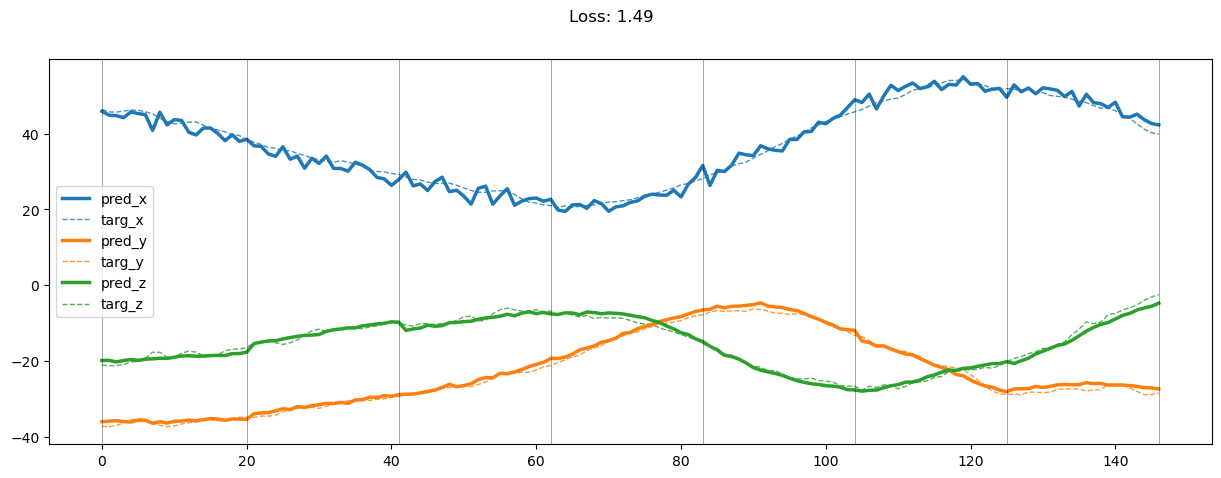

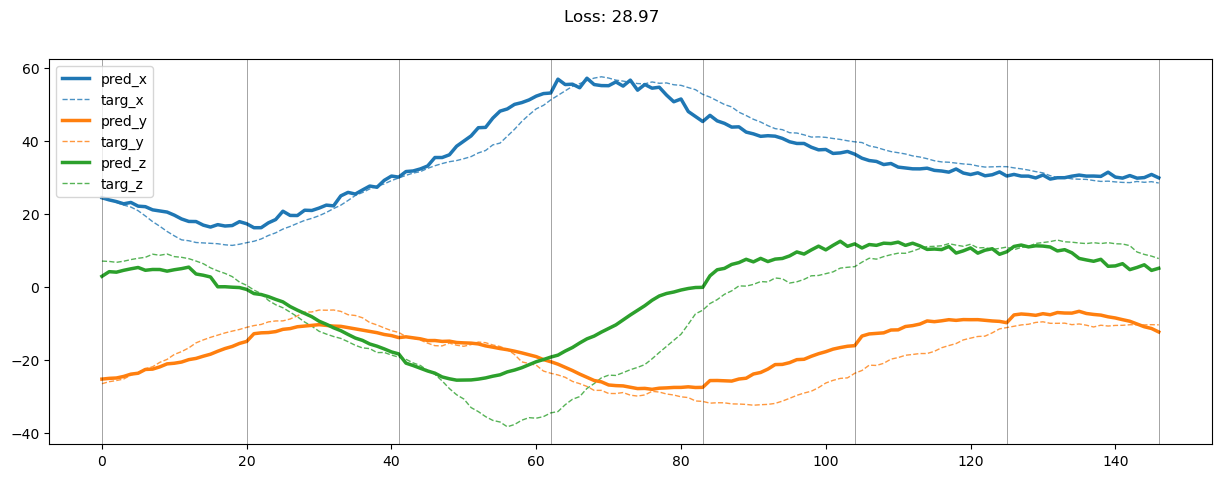

00199: train loss:  7.238, imu loss:  0.682, mag loss:  6.555
       valid loss:  225.090, imu loss:  0.509, mag loss:  224.582
00219: train loss:  6.959, imu loss:  0.672, mag loss:  6.287
       valid loss:  224.692, imu loss:  0.509, mag loss:  224.183
00239: train loss:  7.133, imu loss:  0.674, mag loss:  6.459
       valid loss:  226.668, imu loss:  0.509, mag loss:  226.160
00259: train loss:  7.446, imu loss:  0.684, mag loss:  6.762
       valid loss:  217.028, imu loss:  0.509, mag loss:  216.519
00279: train loss:  7.066, imu loss:  0.680, mag loss:  6.386
       valid loss:  211.777, imu loss:  0.509, mag loss:  211.268
00299: train loss:  7.398, imu loss:  0.673, mag loss:  6.725
       valid loss:  215.772, imu loss:  0.509, mag loss:  215.263
00319: train loss:  7.355, imu loss:  0.674, mag loss:  6.682
       valid loss:  216.481, imu loss:  0.509, mag loss:  215.973
00339: train loss:  7.071, imu loss:  0.676, mag loss:  6.395
       valid loss:  229.598, imu loss:  0.

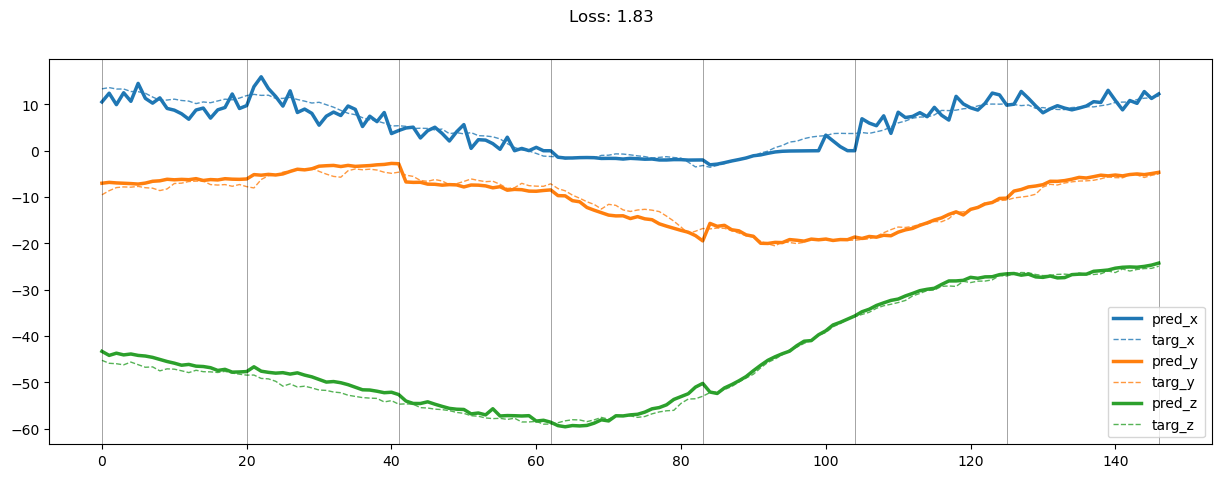

00399: train loss:  7.394, imu loss:  0.674, mag loss:  6.720
       valid loss:  219.350, imu loss:  0.509, mag loss:  218.841
00419: train loss:  6.992, imu loss:  0.686, mag loss:  6.306
       valid loss:  228.669, imu loss:  0.509, mag loss:  228.160
00439: train loss:  6.927, imu loss:  0.674, mag loss:  6.253
       valid loss:  225.482, imu loss:  0.509, mag loss:  224.974
00459: train loss:  6.911, imu loss:  0.675, mag loss:  6.236
       valid loss:  219.351, imu loss:  0.509, mag loss:  218.843
00479: train loss:  7.124, imu loss:  0.680, mag loss:  6.444
       valid loss:  223.278, imu loss:  0.509, mag loss:  222.770
00499: train loss:  7.023, imu loss:  0.681, mag loss:  6.342
       valid loss:  223.704, imu loss:  0.509, mag loss:  223.195
00519: train loss:  7.124, imu loss:  0.674, mag loss:  6.450
       valid loss:  223.575, imu loss:  0.509, mag loss:  223.066
00539: train loss:  6.796, imu loss:  0.678, mag loss:  6.117
       valid loss:  220.423, imu loss:  0.

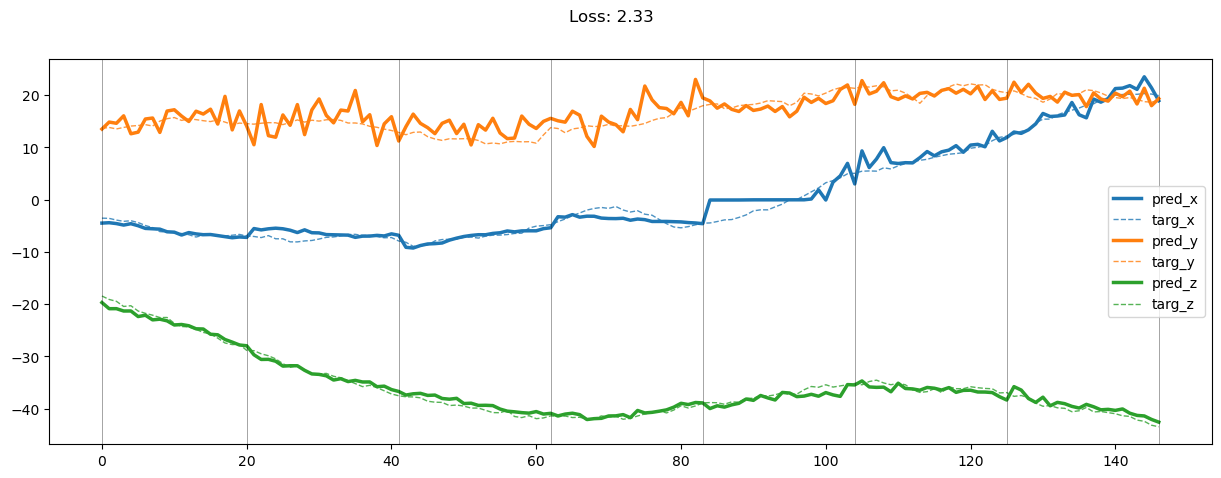

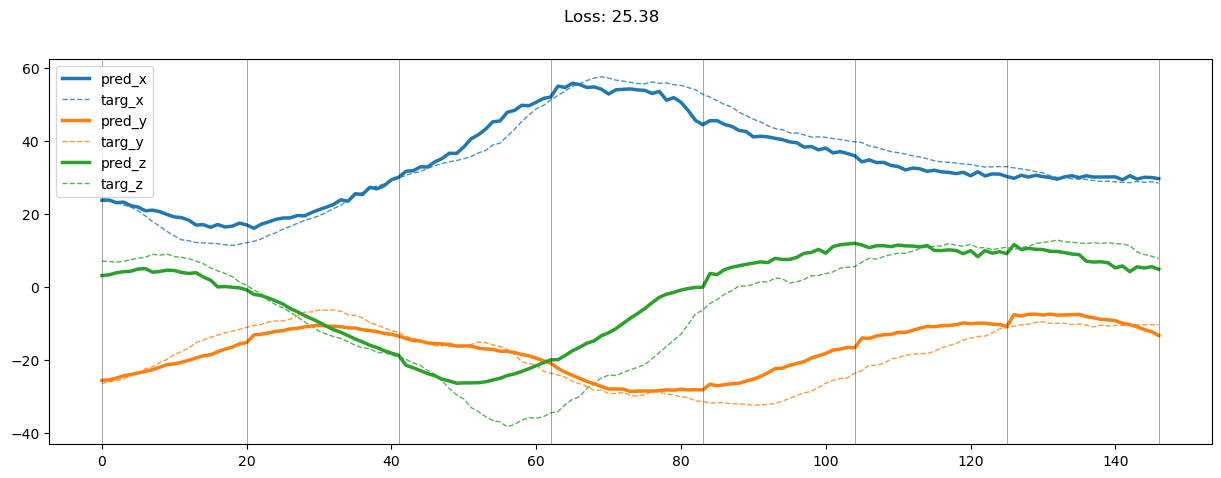

00599: train loss:  6.906, imu loss:  0.681, mag loss:  6.225
       valid loss:  224.009, imu loss:  0.509, mag loss:  223.500
00619: train loss:  6.956, imu loss:  0.676, mag loss:  6.280
       valid loss:  226.707, imu loss:  0.509, mag loss:  226.198
00639: train loss:  6.914, imu loss:  0.687, mag loss:  6.227
       valid loss:  229.452, imu loss:  0.509, mag loss:  228.944
00659: train loss:  6.997, imu loss:  0.677, mag loss:  6.320
       valid loss:  238.932, imu loss:  0.509, mag loss:  238.424
00679: train loss:  6.893, imu loss:  0.678, mag loss:  6.214
       valid loss:  227.297, imu loss:  0.509, mag loss:  226.788
00699: train loss:  6.903, imu loss:  0.684, mag loss:  6.219
       valid loss:  231.729, imu loss:  0.509, mag loss:  231.221
00719: train loss:  6.662, imu loss:  0.674, mag loss:  5.988
       valid loss:  229.563, imu loss:  0.509, mag loss:  229.054
00739: train loss:  6.729, imu loss:  0.675, mag loss:  6.054
       valid loss:  215.224, imu loss:  0.

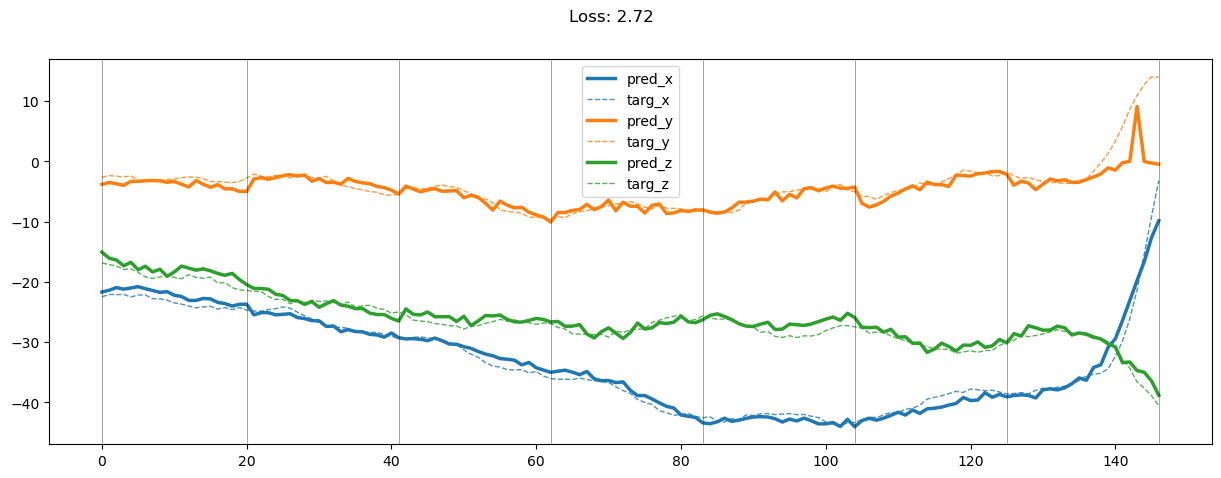

00799: train loss:  6.846, imu loss:  0.680, mag loss:  6.166
       valid loss:  232.437, imu loss:  0.509, mag loss:  231.929
00819: train loss:  6.773, imu loss:  0.676, mag loss:  6.097
       valid loss:  227.274, imu loss:  0.509, mag loss:  226.766
00839: train loss:  6.916, imu loss:  0.679, mag loss:  6.237
       valid loss:  219.172, imu loss:  0.509, mag loss:  218.663
00859: train loss:  6.680, imu loss:  0.682, mag loss:  5.998
       valid loss:  222.608, imu loss:  0.509, mag loss:  222.099
00879: train loss:  6.952, imu loss:  0.681, mag loss:  6.271
       valid loss:  224.909, imu loss:  0.509, mag loss:  224.401
00899: train loss:  6.712, imu loss:  0.678, mag loss:  6.034
       valid loss:  227.058, imu loss:  0.509, mag loss:  226.550
00919: train loss:  7.006, imu loss:  0.679, mag loss:  6.327
       valid loss:  222.831, imu loss:  0.509, mag loss:  222.323
00939: train loss:  6.645, imu loss:  0.683, mag loss:  5.962
       valid loss:  227.003, imu loss:  0.

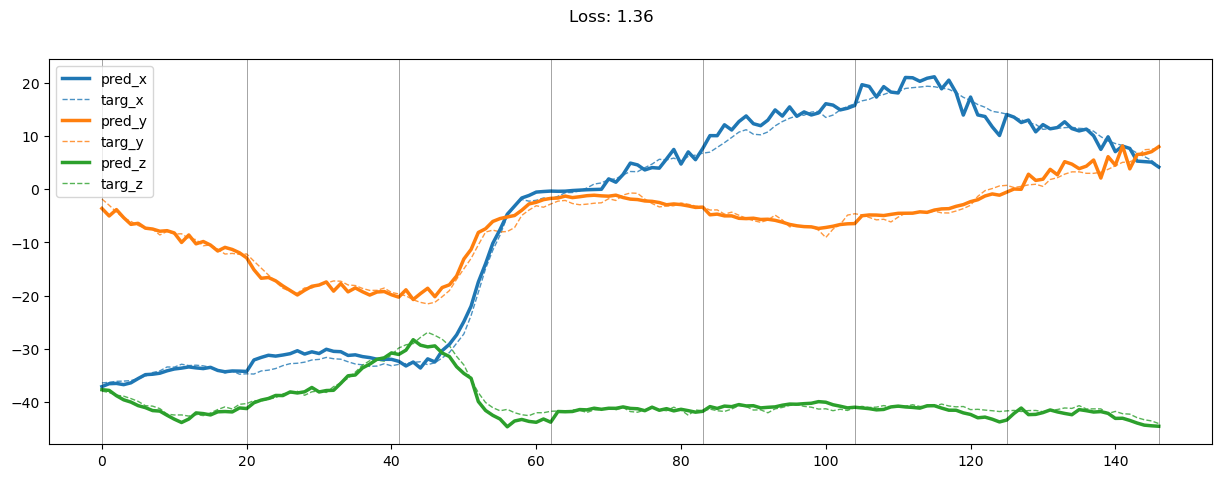

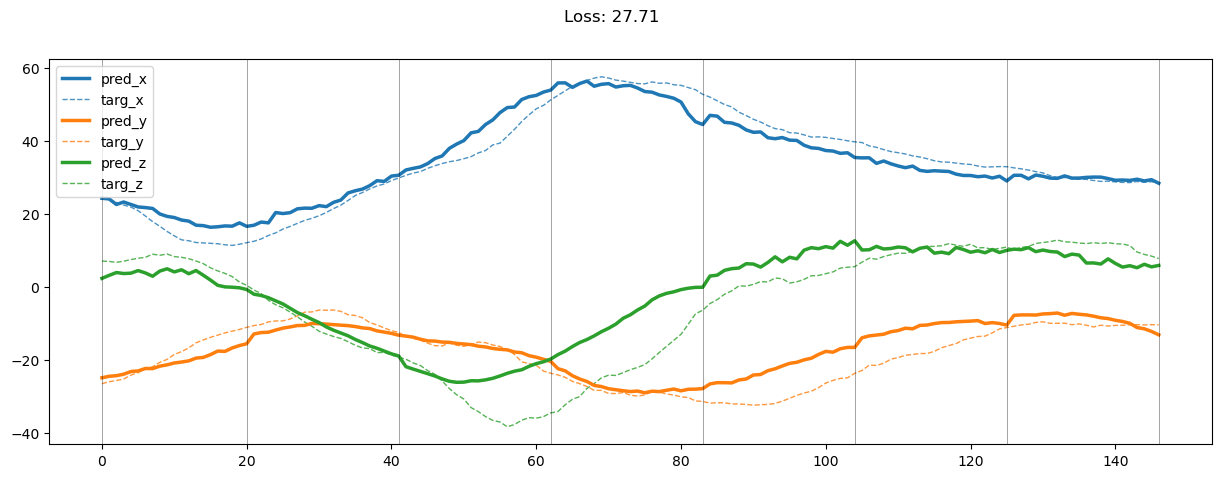

00999: train loss:  6.544, imu loss:  0.672, mag loss:  5.872
       valid loss:  221.347, imu loss:  0.509, mag loss:  220.838
01019: train loss:  6.464, imu loss:  0.676, mag loss:  5.788
       valid loss:  227.719, imu loss:  0.509, mag loss:  227.211
01039: train loss:  6.650, imu loss:  0.681, mag loss:  5.969
       valid loss:  219.741, imu loss:  0.509, mag loss:  219.232
01059: train loss:  6.346, imu loss:  0.664, mag loss:  5.682
       valid loss:  212.166, imu loss:  0.509, mag loss:  211.657
01079: train loss:  6.419, imu loss:  0.685, mag loss:  5.734
       valid loss:  231.365, imu loss:  0.509, mag loss:  230.856
01099: train loss:  6.460, imu loss:  0.681, mag loss:  5.779
       valid loss:  224.813, imu loss:  0.509, mag loss:  224.305
01119: train loss:  6.616, imu loss:  0.680, mag loss:  5.936
       valid loss:  225.062, imu loss:  0.509, mag loss:  224.554
01139: train loss:  6.243, imu loss:  0.673, mag loss:  5.570
       valid loss:  212.941, imu loss:  0.

01199: train loss:  6.706, imu loss:  0.680, mag loss:  6.025
       valid loss:  223.226, imu loss:  0.509, mag loss:  222.717
01219: train loss:  6.522, imu loss:  0.686, mag loss:  5.836
       valid loss:  225.698, imu loss:  0.509, mag loss:  225.189
01239: train loss:  6.415, imu loss:  0.674, mag loss:  5.741
       valid loss:  218.910, imu loss:  0.509, mag loss:  218.402
01259: train loss:  6.388, imu loss:  0.679, mag loss:  5.709
       valid loss:  229.065, imu loss:  0.509, mag loss:  228.556
01279: train loss:  6.362, imu loss:  0.679, mag loss:  5.683
       valid loss:  228.900, imu loss:  0.509, mag loss:  228.392
01299: train loss:  6.357, imu loss:  0.681, mag loss:  5.676
       valid loss:  235.035, imu loss:  0.509, mag loss:  234.526
01319: train loss:  6.638, imu loss:  0.681, mag loss:  5.957
       valid loss:  225.861, imu loss:  0.509, mag loss:  225.352
01339: train loss:  6.282, imu loss:  0.683, mag loss:  5.599
       valid loss:  220.269, imu loss:  0.

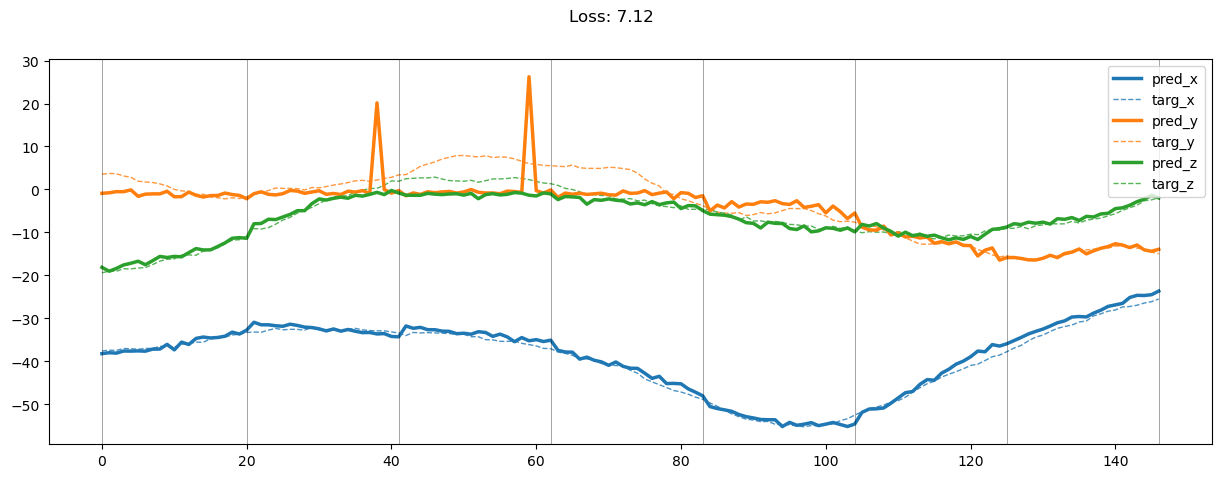

01399: train loss:  6.400, imu loss:  0.674, mag loss:  5.726
       valid loss:  213.852, imu loss:  0.509, mag loss:  213.343
01419: train loss:  6.556, imu loss:  0.673, mag loss:  5.883
       valid loss:  217.078, imu loss:  0.509, mag loss:  216.569
01439: train loss:  6.573, imu loss:  0.687, mag loss:  5.886
       valid loss:  222.082, imu loss:  0.509, mag loss:  221.574
01459: train loss:  6.311, imu loss:  0.678, mag loss:  5.632
       valid loss:  222.259, imu loss:  0.509, mag loss:  221.751
01479: train loss:  6.281, imu loss:  0.681, mag loss:  5.600
       valid loss:  221.624, imu loss:  0.509, mag loss:  221.116
01499: train loss:  6.213, imu loss:  0.678, mag loss:  5.534
       valid loss:  227.673, imu loss:  0.509, mag loss:  227.164
01519: train loss:  6.086, imu loss:  0.680, mag loss:  5.407
       valid loss:  223.603, imu loss:  0.509, mag loss:  223.094
01539: train loss:  6.192, imu loss:  0.672, mag loss:  5.519
       valid loss:  215.771, imu loss:  0.

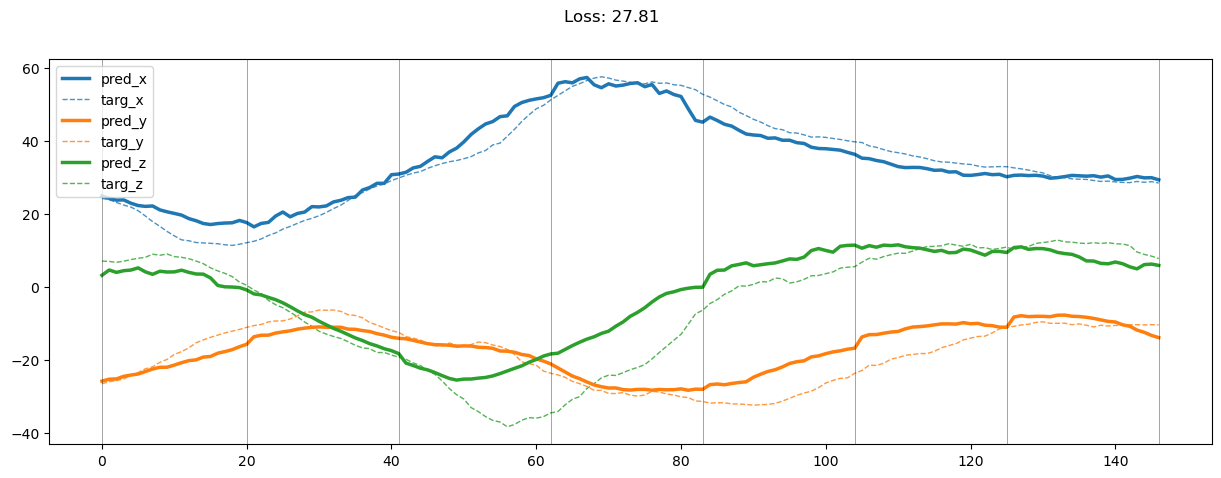

01599: train loss:  6.243, imu loss:  0.678, mag loss:  5.565
       valid loss:  236.304, imu loss:  0.509, mag loss:  235.795
01619: train loss:  6.124, imu loss:  0.681, mag loss:  5.443
       valid loss:  226.695, imu loss:  0.509, mag loss:  226.187
01639: train loss:  6.413, imu loss:  0.682, mag loss:  5.731
       valid loss:  238.549, imu loss:  0.509, mag loss:  238.041
01659: train loss:  6.296, imu loss:  0.683, mag loss:  5.613
       valid loss:  222.760, imu loss:  0.509, mag loss:  222.252
01679: train loss:  6.346, imu loss:  0.686, mag loss:  5.660
       valid loss:  219.903, imu loss:  0.509, mag loss:  219.394
01699: train loss:  5.866, imu loss:  0.674, mag loss:  5.192
       valid loss:  215.885, imu loss:  0.509, mag loss:  215.376
01719: train loss:  6.132, imu loss:  0.668, mag loss:  5.464
       valid loss:  221.285, imu loss:  0.509, mag loss:  220.777
01739: train loss:  6.157, imu loss:  0.674, mag loss:  5.483
       valid loss:  217.279, imu loss:  0.

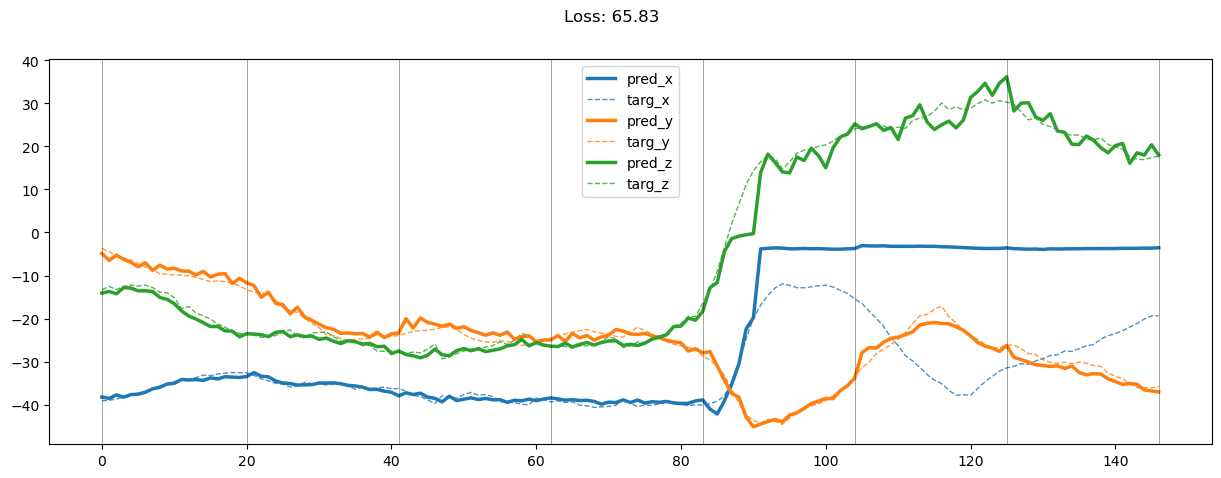

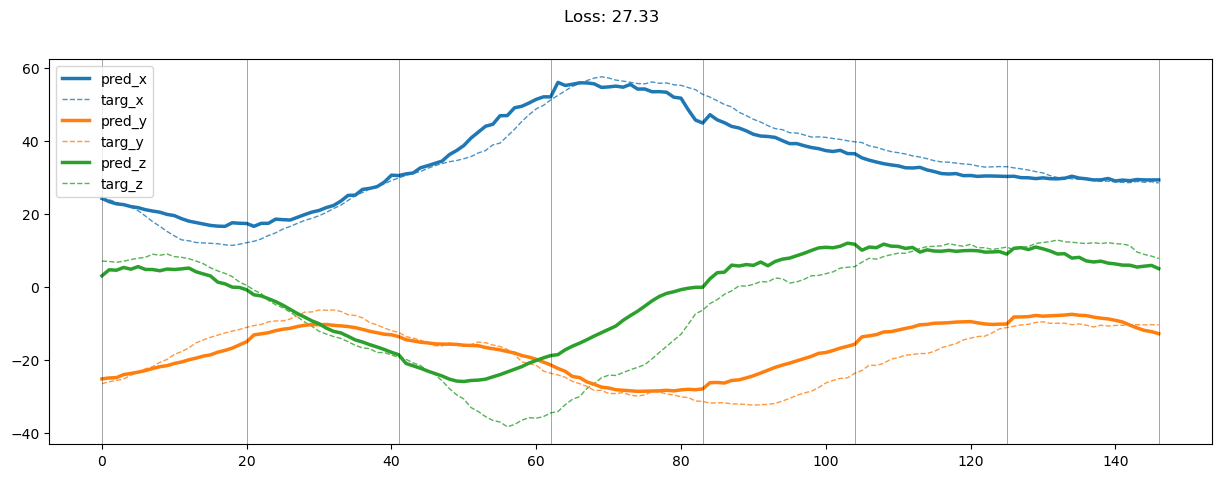

01799: train loss:  6.054, imu loss:  0.682, mag loss:  5.372
       valid loss:  217.893, imu loss:  0.509, mag loss:  217.384
01819: train loss:  6.330, imu loss:  0.678, mag loss:  5.652
       valid loss:  216.649, imu loss:  0.509, mag loss:  216.140
01839: train loss:  5.999, imu loss:  0.676, mag loss:  5.322
       valid loss:  216.501, imu loss:  0.509, mag loss:  215.992
01859: train loss:  5.996, imu loss:  0.676, mag loss:  5.320
       valid loss:  212.355, imu loss:  0.509, mag loss:  211.846
01879: train loss:  5.890, imu loss:  0.676, mag loss:  5.215
       valid loss:  217.329, imu loss:  0.509, mag loss:  216.820
01899: train loss:  6.004, imu loss:  0.682, mag loss:  5.322
       valid loss:  218.521, imu loss:  0.509, mag loss:  218.012
01919: train loss:  5.714, imu loss:  0.675, mag loss:  5.039
       valid loss:  219.062, imu loss:  0.509, mag loss:  218.553
01939: train loss:  5.934, imu loss:  0.676, mag loss:  5.258
       valid loss:  216.055, imu loss:  0.

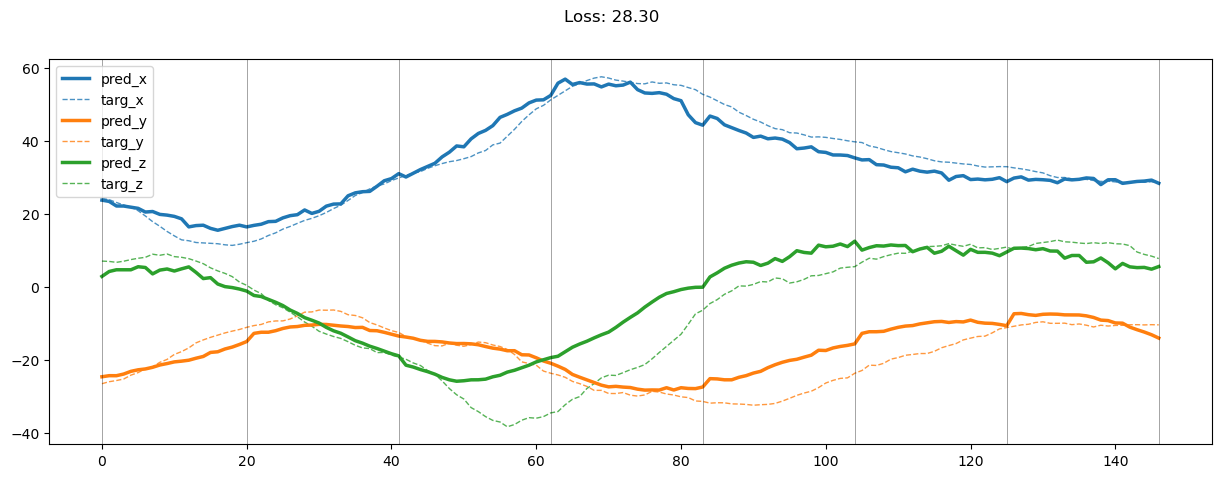

01999: train loss:  6.030, imu loss:  0.685, mag loss:  5.345
       valid loss:  221.071, imu loss:  0.509, mag loss:  220.563
02019: train loss:  5.897, imu loss:  0.681, mag loss:  5.216
       valid loss:  220.172, imu loss:  0.509, mag loss:  219.663
02039: train loss:  6.130, imu loss:  0.676, mag loss:  5.454
       valid loss:  220.086, imu loss:  0.509, mag loss:  219.578
02059: train loss:  5.839, imu loss:  0.683, mag loss:  5.155
       valid loss:  212.092, imu loss:  0.509, mag loss:  211.583
02079: train loss:  5.833, imu loss:  0.676, mag loss:  5.157
       valid loss:  216.046, imu loss:  0.509, mag loss:  215.538
02099: train loss:  5.900, imu loss:  0.680, mag loss:  5.220
       valid loss:  217.815, imu loss:  0.509, mag loss:  217.307
02119: train loss:  5.583, imu loss:  0.675, mag loss:  4.908
       valid loss:  215.422, imu loss:  0.509, mag loss:  214.913
02139: train loss:  5.859, imu loss:  0.675, mag loss:  5.184
       valid loss:  215.151, imu loss:  0.

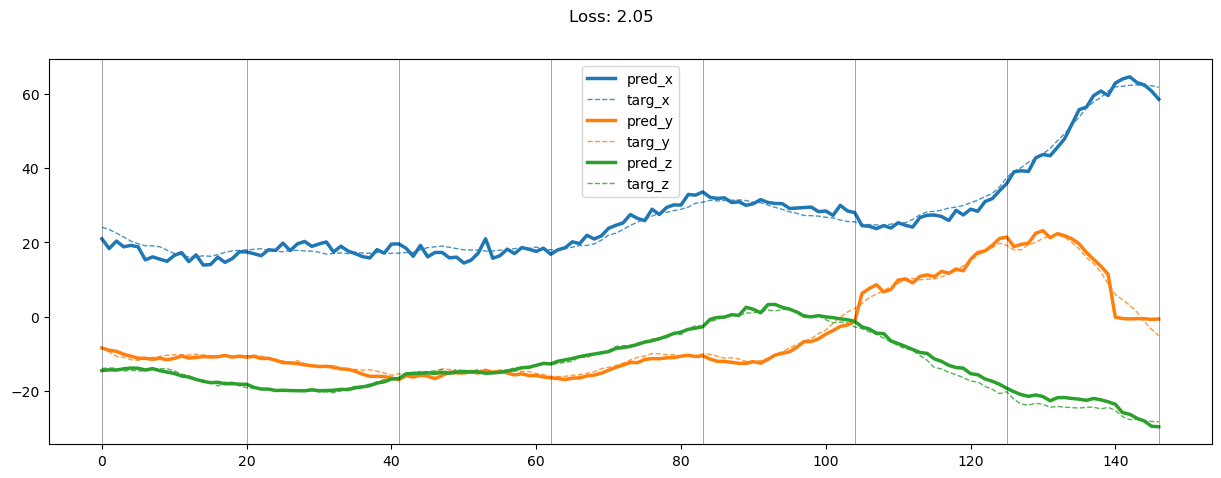

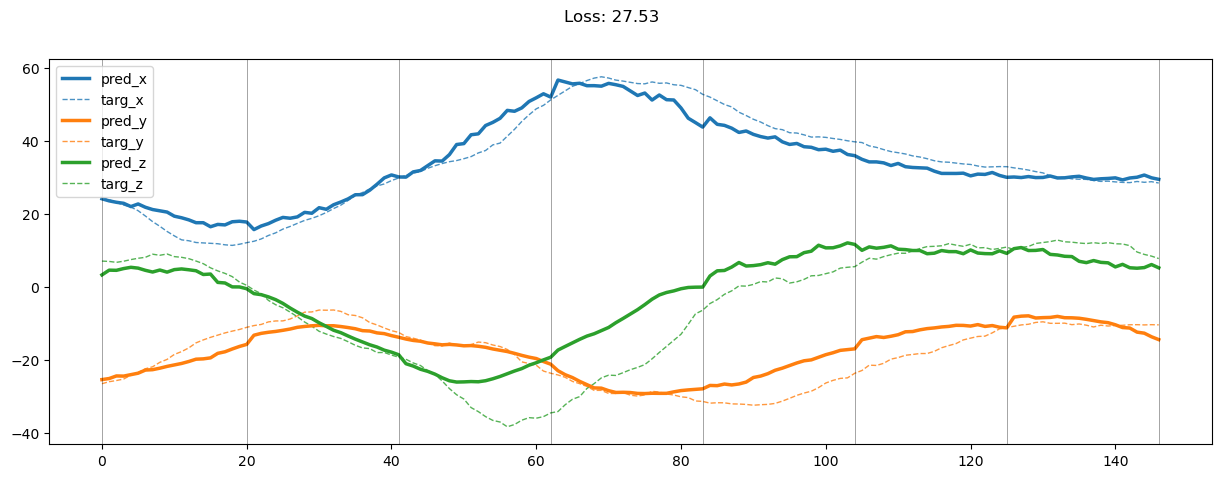

02199: train loss:  5.715, imu loss:  0.668, mag loss:  5.047
       valid loss:  213.110, imu loss:  0.509, mag loss:  212.601
02219: train loss:  5.880, imu loss:  0.674, mag loss:  5.205
       valid loss:  215.511, imu loss:  0.509, mag loss:  215.002
02239: train loss:  5.723, imu loss:  0.676, mag loss:  5.046
       valid loss:  212.889, imu loss:  0.509, mag loss:  212.380
02259: train loss:  5.764, imu loss:  0.679, mag loss:  5.085
       valid loss:  215.450, imu loss:  0.509, mag loss:  214.941
02279: train loss:  5.763, imu loss:  0.675, mag loss:  5.088
       valid loss:  213.459, imu loss:  0.509, mag loss:  212.951
02299: train loss:  5.727, imu loss:  0.681, mag loss:  5.046
       valid loss:  216.295, imu loss:  0.509, mag loss:  215.786
02319: train loss:  5.785, imu loss:  0.679, mag loss:  5.107
       valid loss:  212.504, imu loss:  0.509, mag loss:  211.996
02339: train loss:  5.668, imu loss:  0.679, mag loss:  4.989
       valid loss:  208.929, imu loss:  0.

02399: train loss:  5.669, imu loss:  0.675, mag loss:  4.994
       valid loss:  213.968, imu loss:  0.509, mag loss:  213.460
02419: train loss:  5.636, imu loss:  0.676, mag loss:  4.960
       valid loss:  213.478, imu loss:  0.509, mag loss:  212.969
02439: train loss:  5.545, imu loss:  0.677, mag loss:  4.867
       valid loss:  220.887, imu loss:  0.509, mag loss:  220.378
02459: train loss:  5.814, imu loss:  0.681, mag loss:  5.133
       valid loss:  214.264, imu loss:  0.509, mag loss:  213.756
02479: train loss:  5.592, imu loss:  0.670, mag loss:  4.922
       valid loss:  209.616, imu loss:  0.509, mag loss:  209.107
02499: train loss:  5.605, imu loss:  0.681, mag loss:  4.924
       valid loss:  223.836, imu loss:  0.509, mag loss:  223.328
02519: train loss:  5.862, imu loss:  0.680, mag loss:  5.182
       valid loss:  211.013, imu loss:  0.509, mag loss:  210.504
02539: train loss:  5.572, imu loss:  0.687, mag loss:  4.885
       valid loss:  217.730, imu loss:  0.

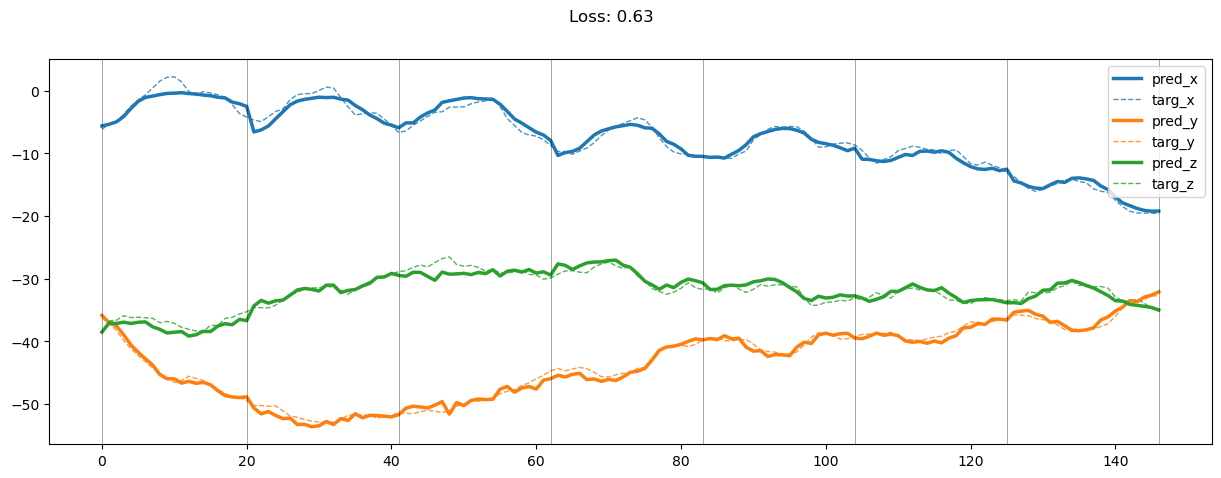

02599: train loss:  5.405, imu loss:  0.681, mag loss:  4.724
       valid loss:  213.365, imu loss:  0.509, mag loss:  212.856
02619: train loss:  5.556, imu loss:  0.680, mag loss:  4.876
       valid loss:  208.301, imu loss:  0.509, mag loss:  207.792
02639: train loss:  5.572, imu loss:  0.682, mag loss:  4.891
       valid loss:  210.436, imu loss:  0.509, mag loss:  209.928
02659: train loss:  5.322, imu loss:  0.676, mag loss:  4.646
       valid loss:  213.663, imu loss:  0.509, mag loss:  213.155
02679: train loss:  5.310, imu loss:  0.671, mag loss:  4.640
       valid loss:  215.166, imu loss:  0.509, mag loss:  214.658
02699: train loss:  5.345, imu loss:  0.673, mag loss:  4.672
       valid loss:  208.678, imu loss:  0.509, mag loss:  208.170
02719: train loss:  5.316, imu loss:  0.676, mag loss:  4.640
       valid loss:  214.627, imu loss:  0.509, mag loss:  214.118
02739: train loss:  5.251, imu loss:  0.680, mag loss:  4.571
       valid loss:  208.830, imu loss:  0.

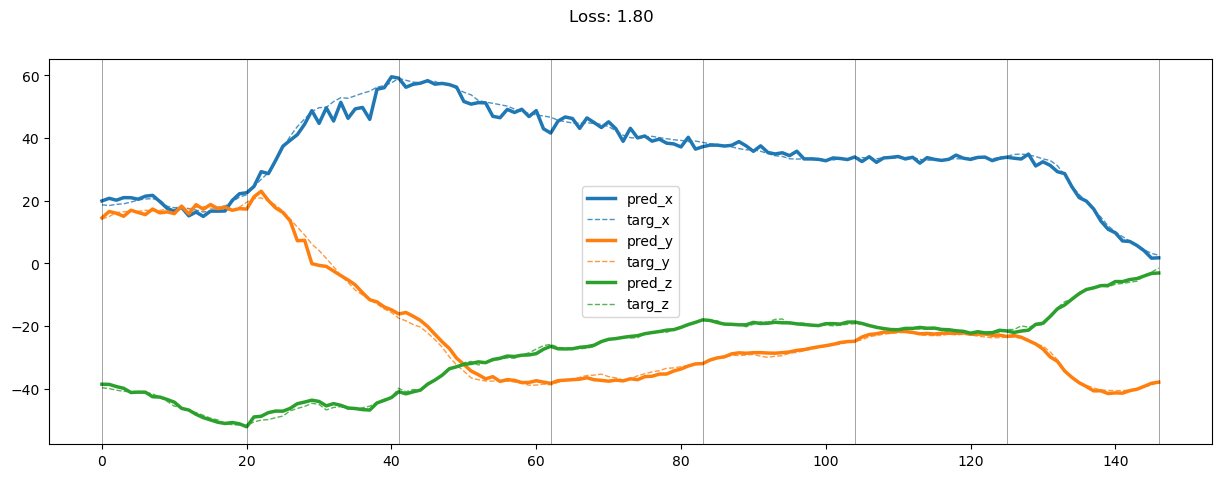

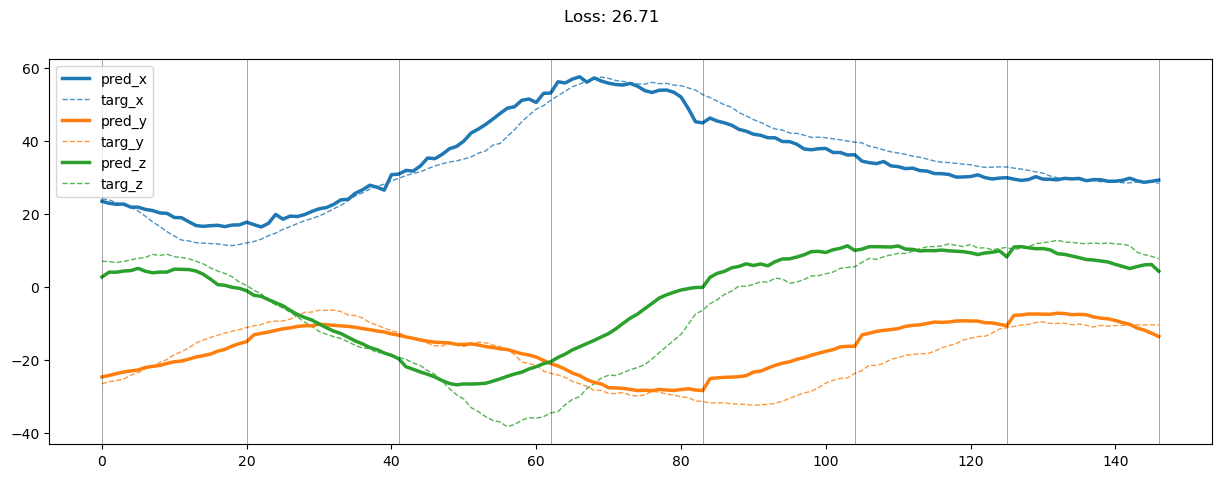

02799: train loss:  5.404, imu loss:  0.680, mag loss:  4.724
       valid loss:  212.743, imu loss:  0.509, mag loss:  212.235
02819: train loss:  5.338, imu loss:  0.673, mag loss:  4.664
       valid loss:  211.416, imu loss:  0.509, mag loss:  210.908
02839: train loss:  5.175, imu loss:  0.680, mag loss:  4.496
       valid loss:  210.389, imu loss:  0.509, mag loss:  209.880
02859: train loss:  5.294, imu loss:  0.675, mag loss:  4.619
       valid loss:  213.420, imu loss:  0.509, mag loss:  212.911
02879: train loss:  5.434, imu loss:  0.680, mag loss:  4.754
       valid loss:  207.675, imu loss:  0.509, mag loss:  207.167
02899: train loss:  5.137, imu loss:  0.670, mag loss:  4.467
       valid loss:  209.014, imu loss:  0.509, mag loss:  208.505
02919: train loss:  5.191, imu loss:  0.677, mag loss:  4.514
       valid loss:  209.839, imu loss:  0.509, mag loss:  209.330
02939: train loss:  5.247, imu loss:  0.676, mag loss:  4.570
       valid loss:  210.300, imu loss:  0.

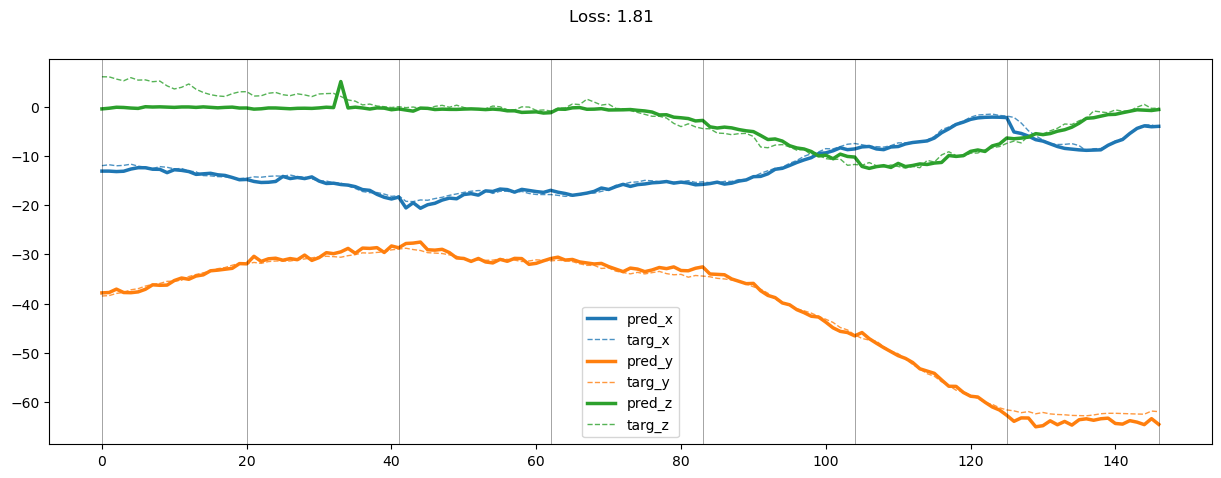

02999: train loss:  5.228, imu loss:  0.671, mag loss:  4.557
       valid loss:  213.638, imu loss:  0.509, mag loss:  213.129
03019: train loss:  5.356, imu loss:  0.677, mag loss:  4.679
       valid loss:  212.948, imu loss:  0.509, mag loss:  212.440
03039: train loss:  5.045, imu loss:  0.679, mag loss:  4.366
       valid loss:  211.647, imu loss:  0.509, mag loss:  211.139
03059: train loss:  5.376, imu loss:  0.685, mag loss:  4.691
       valid loss:  206.276, imu loss:  0.509, mag loss:  205.768
03079: train loss:  5.186, imu loss:  0.671, mag loss:  4.515
       valid loss:  209.443, imu loss:  0.509, mag loss:  208.935
03099: train loss:  5.299, imu loss:  0.680, mag loss:  4.619
       valid loss:  210.867, imu loss:  0.509, mag loss:  210.358
03119: train loss:  5.140, imu loss:  0.674, mag loss:  4.466
       valid loss:  206.238, imu loss:  0.509, mag loss:  205.729
03139: train loss:  5.178, imu loss:  0.676, mag loss:  4.502
       valid loss:  207.871, imu loss:  0.

03199: train loss:  5.155, imu loss:  0.672, mag loss:  4.483
       valid loss:  207.668, imu loss:  0.509, mag loss:  207.159
03219: train loss:  5.068, imu loss:  0.674, mag loss:  4.394
       valid loss:  210.249, imu loss:  0.509, mag loss:  209.741
03239: train loss:  5.228, imu loss:  0.676, mag loss:  4.551
       valid loss:  211.472, imu loss:  0.509, mag loss:  210.963
03259: train loss:  5.161, imu loss:  0.678, mag loss:  4.483
       valid loss:  207.657, imu loss:  0.509, mag loss:  207.148
03279: train loss:  5.129, imu loss:  0.680, mag loss:  4.450
       valid loss:  207.069, imu loss:  0.509, mag loss:  206.561
03299: train loss:  5.216, imu loss:  0.683, mag loss:  4.533
       valid loss:  211.343, imu loss:  0.509, mag loss:  210.835
03319: train loss:  5.188, imu loss:  0.672, mag loss:  4.515
       valid loss:  215.570, imu loss:  0.509, mag loss:  215.061
03339: train loss:  5.256, imu loss:  0.684, mag loss:  4.572
       valid loss:  210.914, imu loss:  0.

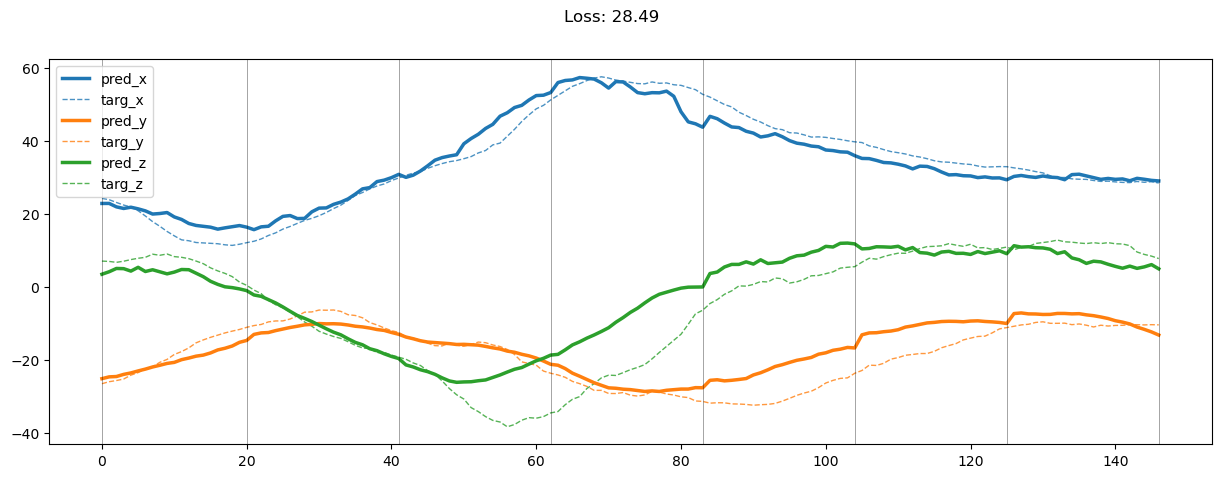

03399: train loss:  4.996, imu loss:  0.679, mag loss:  4.317
       valid loss:  220.912, imu loss:  0.509, mag loss:  220.403
03419: train loss:  4.836, imu loss:  0.674, mag loss:  4.162
       valid loss:  214.063, imu loss:  0.509, mag loss:  213.554
03439: train loss:  5.076, imu loss:  0.677, mag loss:  4.400
       valid loss:  208.213, imu loss:  0.509, mag loss:  207.704
03459: train loss:  5.027, imu loss:  0.680, mag loss:  4.346
       valid loss:  219.033, imu loss:  0.509, mag loss:  218.524
03479: train loss:  5.125, imu loss:  0.683, mag loss:  4.442
       valid loss:  217.472, imu loss:  0.509, mag loss:  216.963
03499: train loss:  5.080, imu loss:  0.684, mag loss:  4.396
       valid loss:  218.652, imu loss:  0.509, mag loss:  218.144
03519: train loss:  5.027, imu loss:  0.676, mag loss:  4.351
       valid loss:  214.869, imu loss:  0.509, mag loss:  214.361
03539: train loss:  5.069, imu loss:  0.684, mag loss:  4.385
       valid loss:  217.302, imu loss:  0.

03599: train loss:  4.948, imu loss:  0.681, mag loss:  4.267
       valid loss:  214.753, imu loss:  0.509, mag loss:  214.245
03619: train loss:  4.684, imu loss:  0.679, mag loss:  4.005
       valid loss:  208.863, imu loss:  0.509, mag loss:  208.354
03639: train loss:  5.133, imu loss:  0.680, mag loss:  4.453
       valid loss:  212.055, imu loss:  0.509, mag loss:  211.546
03659: train loss:  4.847, imu loss:  0.678, mag loss:  4.169
       valid loss:  207.992, imu loss:  0.509, mag loss:  207.484
03679: train loss:  4.576, imu loss:  0.683, mag loss:  3.892
       valid loss:  208.053, imu loss:  0.509, mag loss:  207.544
03699: train loss:  4.635, imu loss:  0.679, mag loss:  3.956
       valid loss:  213.081, imu loss:  0.509, mag loss:  212.573
03719: train loss:  4.577, imu loss:  0.679, mag loss:  3.899
       valid loss:  218.069, imu loss:  0.509, mag loss:  217.560
03739: train loss:  4.638, imu loss:  0.681, mag loss:  3.957
       valid loss:  215.611, imu loss:  0.

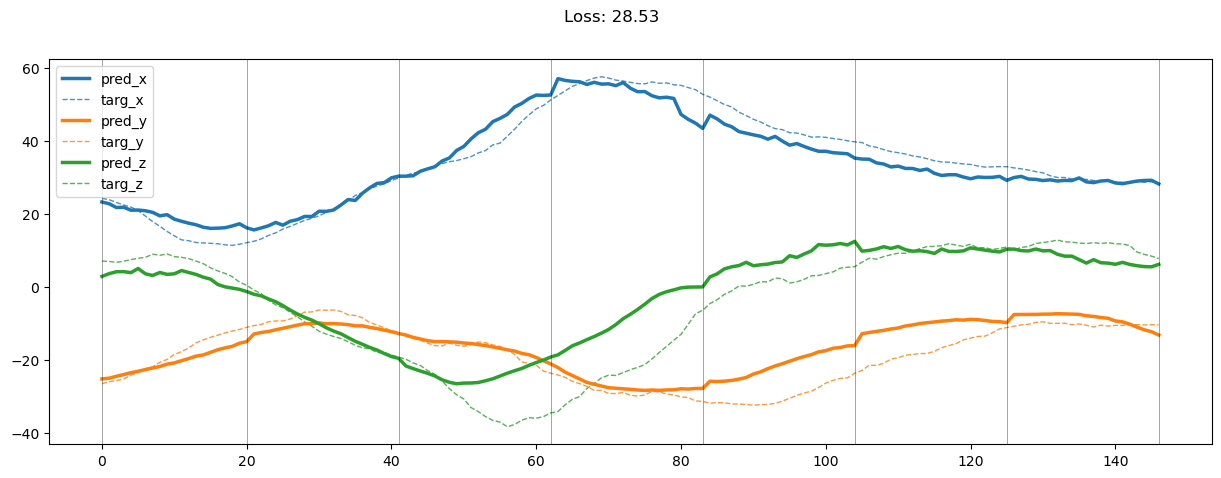

03799: train loss:  4.716, imu loss:  0.683, mag loss:  4.033
       valid loss:  211.899, imu loss:  0.509, mag loss:  211.390
03819: train loss:  4.565, imu loss:  0.678, mag loss:  3.887
       valid loss:  215.594, imu loss:  0.509, mag loss:  215.085
03839: train loss:  4.526, imu loss:  0.676, mag loss:  3.849
       valid loss:  215.629, imu loss:  0.509, mag loss:  215.120
03859: train loss:  4.570, imu loss:  0.677, mag loss:  3.894
       valid loss:  211.925, imu loss:  0.509, mag loss:  211.417
03879: train loss:  4.449, imu loss:  0.678, mag loss:  3.771
       valid loss:  212.744, imu loss:  0.509, mag loss:  212.235
03899: train loss:  4.502, imu loss:  0.676, mag loss:  3.826
       valid loss:  211.860, imu loss:  0.509, mag loss:  211.352
03919: train loss:  4.437, imu loss:  0.674, mag loss:  3.763
       valid loss:  214.662, imu loss:  0.509, mag loss:  214.154
03939: train loss:  4.479, imu loss:  0.696, mag loss:  3.784
       valid loss:  209.304, imu loss:  0.

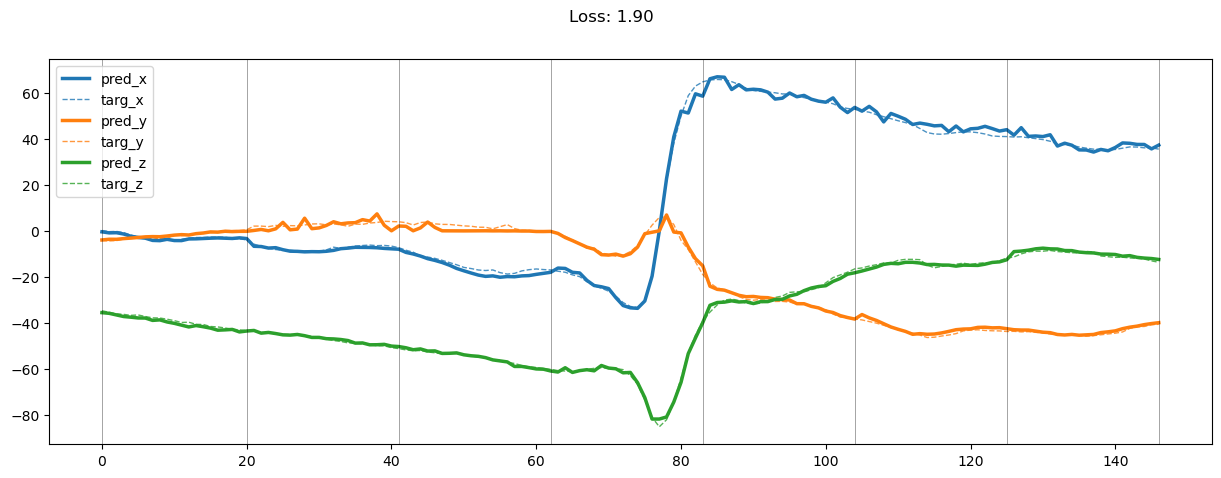

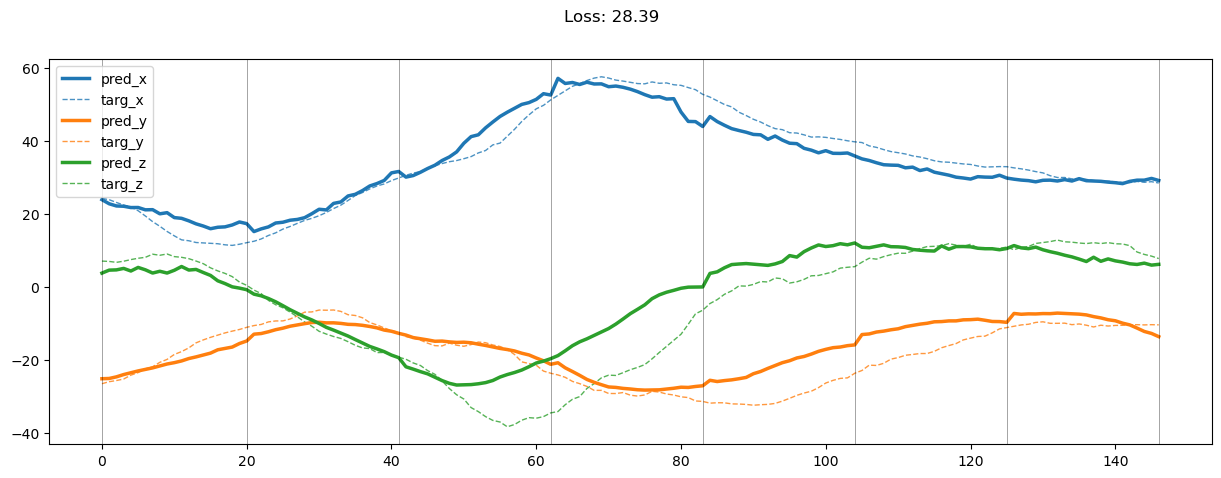

03999: train loss:  4.359, imu loss:  0.678, mag loss:  3.681
       valid loss:  210.073, imu loss:  0.509, mag loss:  209.564
04019: train loss:  4.593, imu loss:  0.680, mag loss:  3.912
       valid loss:  211.710, imu loss:  0.509, mag loss:  211.201
04039: train loss:  4.579, imu loss:  0.678, mag loss:  3.901
       valid loss:  210.929, imu loss:  0.509, mag loss:  210.420
04059: train loss:  4.573, imu loss:  0.677, mag loss:  3.896
       valid loss:  214.667, imu loss:  0.509, mag loss:  214.159
04079: train loss:  4.547, imu loss:  0.679, mag loss:  3.868
       valid loss:  214.592, imu loss:  0.509, mag loss:  214.084
04099: train loss:  4.695, imu loss:  0.677, mag loss:  4.018
       valid loss:  215.664, imu loss:  0.509, mag loss:  215.156
04119: train loss:  4.808, imu loss:  0.679, mag loss:  4.129
       valid loss:  211.603, imu loss:  0.509, mag loss:  211.094
04139: train loss:  4.584, imu loss:  0.673, mag loss:  3.910
       valid loss:  215.328, imu loss:  0.

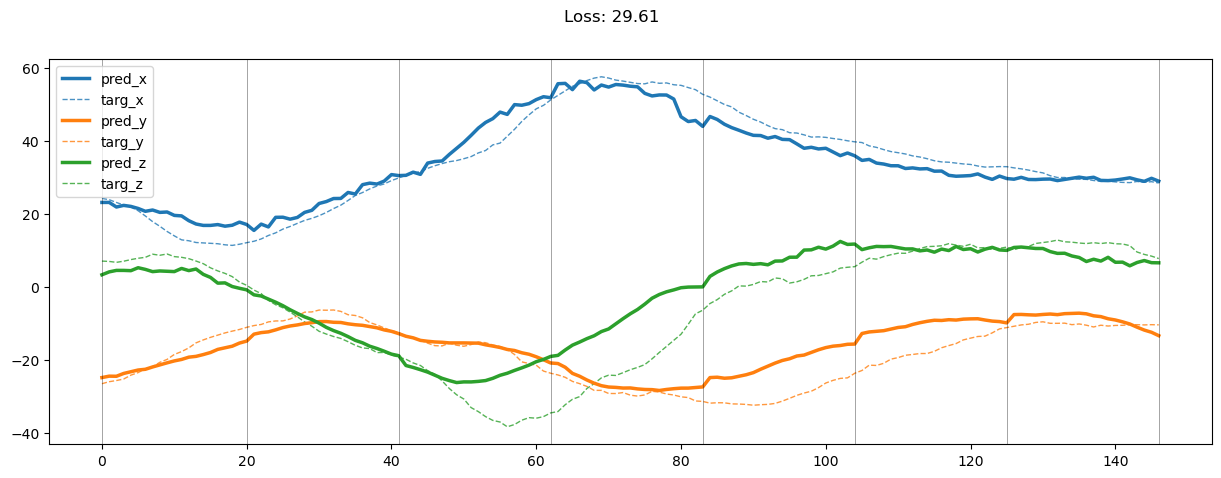

04199: train loss:  4.420, imu loss:  0.678, mag loss:  3.742
       valid loss:  215.718, imu loss:  0.509, mag loss:  215.209
04219: train loss:  4.471, imu loss:  0.673, mag loss:  3.798
       valid loss:  210.207, imu loss:  0.509, mag loss:  209.698
04239: train loss:  4.454, imu loss:  0.678, mag loss:  3.776
       valid loss:  208.553, imu loss:  0.509, mag loss:  208.045
04259: train loss:  4.314, imu loss:  0.678, mag loss:  3.635
       valid loss:  212.524, imu loss:  0.509, mag loss:  212.015
04279: train loss:  4.410, imu loss:  0.676, mag loss:  3.733
       valid loss:  212.121, imu loss:  0.509, mag loss:  211.613
04299: train loss:  4.430, imu loss:  0.677, mag loss:  3.753
       valid loss:  212.055, imu loss:  0.509, mag loss:  211.546
04319: train loss:  4.531, imu loss:  0.683, mag loss:  3.848
       valid loss:  217.529, imu loss:  0.509, mag loss:  217.020
04339: train loss:  4.368, imu loss:  0.677, mag loss:  3.691
       valid loss:  213.789, imu loss:  0.

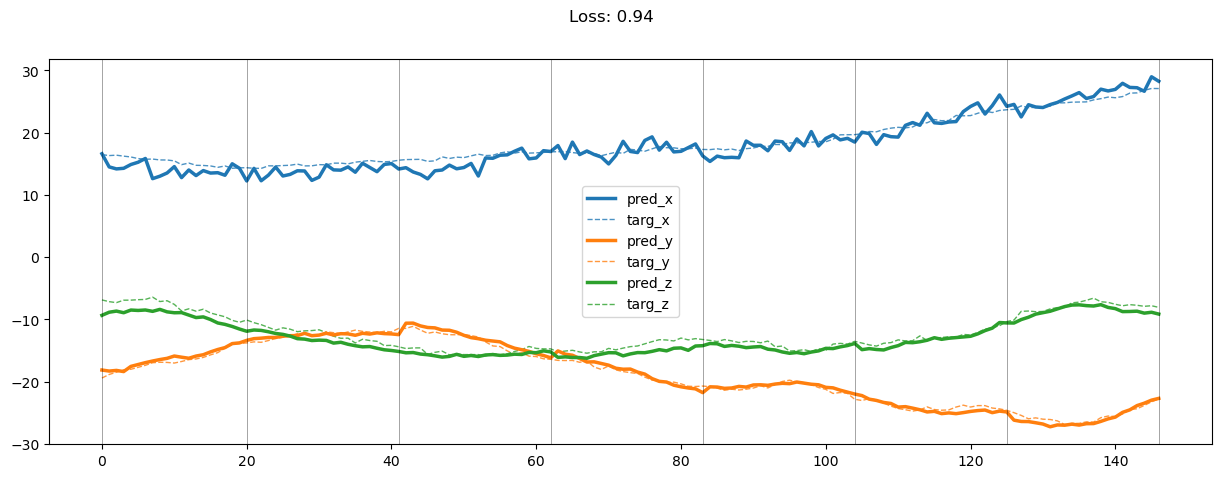

04399: train loss:  4.260, imu loss:  0.677, mag loss:  3.583
       valid loss:  217.262, imu loss:  0.509, mag loss:  216.754
04419: train loss:  4.244, imu loss:  0.678, mag loss:  3.566
       valid loss:  213.486, imu loss:  0.509, mag loss:  212.978
04439: train loss:  4.269, imu loss:  0.675, mag loss:  3.594
       valid loss:  218.662, imu loss:  0.509, mag loss:  218.154
04459: train loss:  4.235, imu loss:  0.681, mag loss:  3.554
       valid loss:  216.265, imu loss:  0.509, mag loss:  215.756
04479: train loss:  4.318, imu loss:  0.681, mag loss:  3.637
       valid loss:  217.767, imu loss:  0.509, mag loss:  217.258
04499: train loss:  4.355, imu loss:  0.678, mag loss:  3.677
       valid loss:  216.915, imu loss:  0.509, mag loss:  216.406
04519: train loss:  4.329, imu loss:  0.677, mag loss:  3.652
       valid loss:  215.454, imu loss:  0.509, mag loss:  214.945
04539: train loss:  4.249, imu loss:  0.680, mag loss:  3.569
       valid loss:  213.996, imu loss:  0.

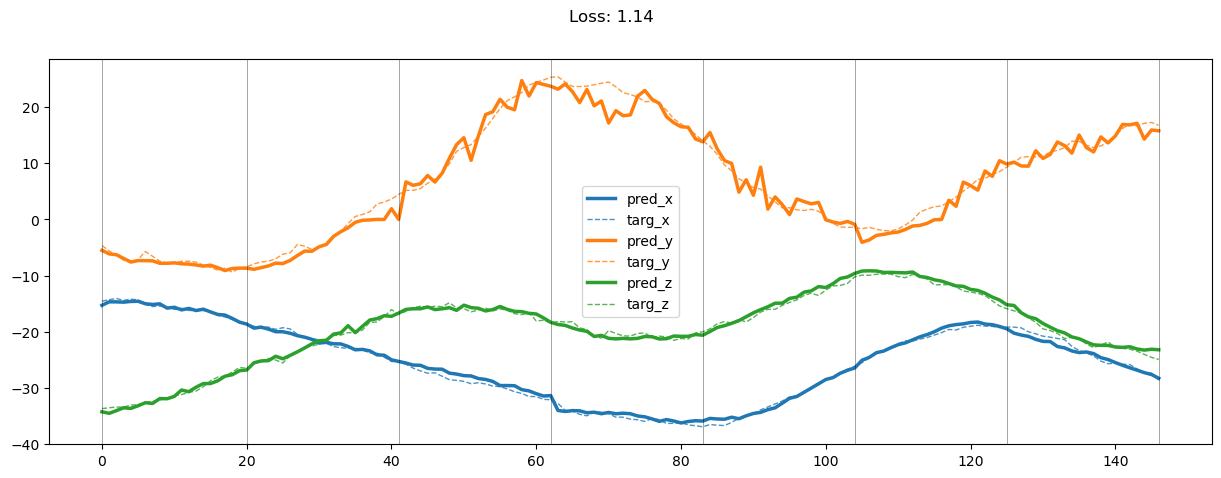

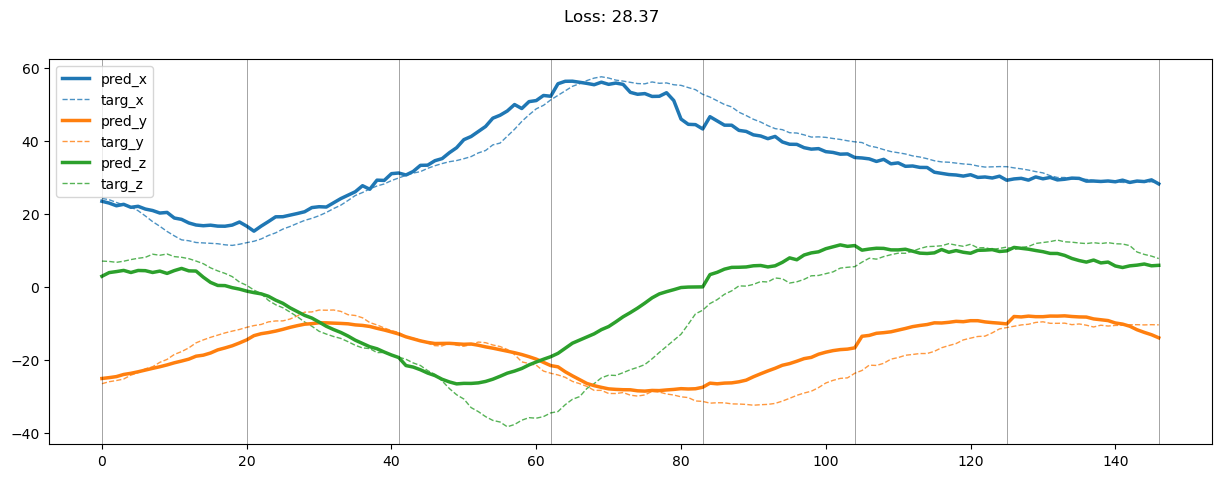

04599: train loss:  4.209, imu loss:  0.670, mag loss:  3.539
       valid loss:  213.029, imu loss:  0.509, mag loss:  212.521
04619: train loss:  4.329, imu loss:  0.683, mag loss:  3.645
       valid loss:  219.714, imu loss:  0.509, mag loss:  219.205
04639: train loss:  4.334, imu loss:  0.675, mag loss:  3.659
       valid loss:  210.072, imu loss:  0.509, mag loss:  209.563
04659: train loss:  4.200, imu loss:  0.679, mag loss:  3.521
       valid loss:  212.864, imu loss:  0.509, mag loss:  212.355
04679: train loss:  4.358, imu loss:  0.688, mag loss:  3.670
       valid loss:  212.510, imu loss:  0.509, mag loss:  212.001
04699: train loss:  4.378, imu loss:  0.680, mag loss:  3.698
       valid loss:  211.082, imu loss:  0.509, mag loss:  210.574
04719: train loss:  4.314, imu loss:  0.679, mag loss:  3.634
       valid loss:  208.915, imu loss:  0.509, mag loss:  208.407
04739: train loss:  4.206, imu loss:  0.682, mag loss:  3.525
       valid loss:  207.137, imu loss:  0.

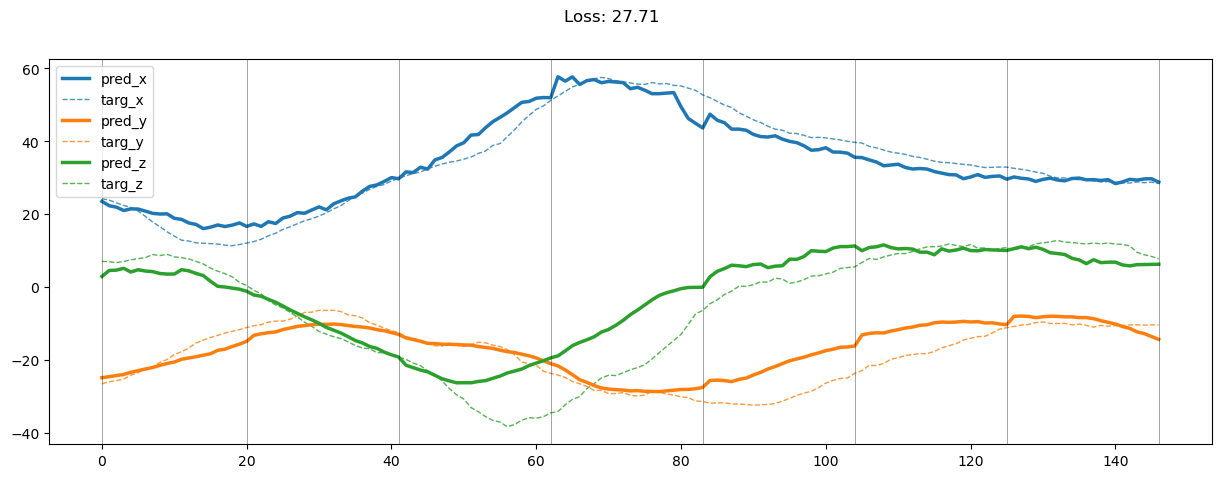

04799: train loss:  4.320, imu loss:  0.677, mag loss:  3.642
       valid loss:  209.328, imu loss:  0.509, mag loss:  208.820
04819: train loss:  4.355, imu loss:  0.681, mag loss:  3.673
       valid loss:  216.651, imu loss:  0.509, mag loss:  216.143
04839: train loss:  4.159, imu loss:  0.675, mag loss:  3.484
       valid loss:  212.493, imu loss:  0.509, mag loss:  211.984
04859: train loss:  4.252, imu loss:  0.680, mag loss:  3.572
       valid loss:  210.769, imu loss:  0.509, mag loss:  210.260
04879: train loss:  4.134, imu loss:  0.687, mag loss:  3.447
       valid loss:  208.001, imu loss:  0.509, mag loss:  207.493
04899: train loss:  4.038, imu loss:  0.675, mag loss:  3.364
       valid loss:  212.462, imu loss:  0.509, mag loss:  211.953
04919: train loss:  4.372, imu loss:  0.678, mag loss:  3.694
       valid loss:  209.423, imu loss:  0.509, mag loss:  208.914
04939: train loss:  4.327, imu loss:  0.679, mag loss:  3.649
       valid loss:  208.793, imu loss:  0.

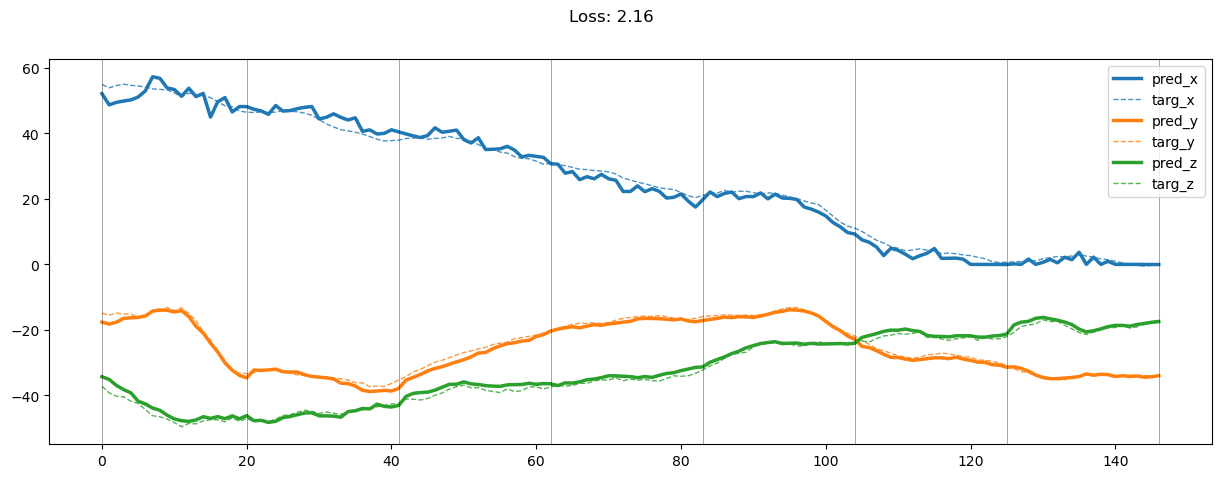

04999: train loss:  4.331, imu loss:  0.671, mag loss:  3.660
       valid loss:  209.568, imu loss:  0.509, mag loss:  209.060
05019: train loss:  4.161, imu loss:  0.677, mag loss:  3.484
       valid loss:  208.141, imu loss:  0.509, mag loss:  207.633
05039: train loss:  4.277, imu loss:  0.671, mag loss:  3.606
       valid loss:  208.040, imu loss:  0.509, mag loss:  207.531
05059: train loss:  4.166, imu loss:  0.683, mag loss:  3.483
       valid loss:  207.233, imu loss:  0.509, mag loss:  206.724
05079: train loss:  4.115, imu loss:  0.678, mag loss:  3.437
       valid loss:  215.845, imu loss:  0.509, mag loss:  215.337
05099: train loss:  4.384, imu loss:  0.677, mag loss:  3.707
       valid loss:  209.193, imu loss:  0.509, mag loss:  208.685
05119: train loss:  4.205, imu loss:  0.685, mag loss:  3.520
       valid loss:  211.729, imu loss:  0.509, mag loss:  211.220
05139: train loss:  4.016, imu loss:  0.673, mag loss:  3.343
       valid loss:  214.343, imu loss:  0.

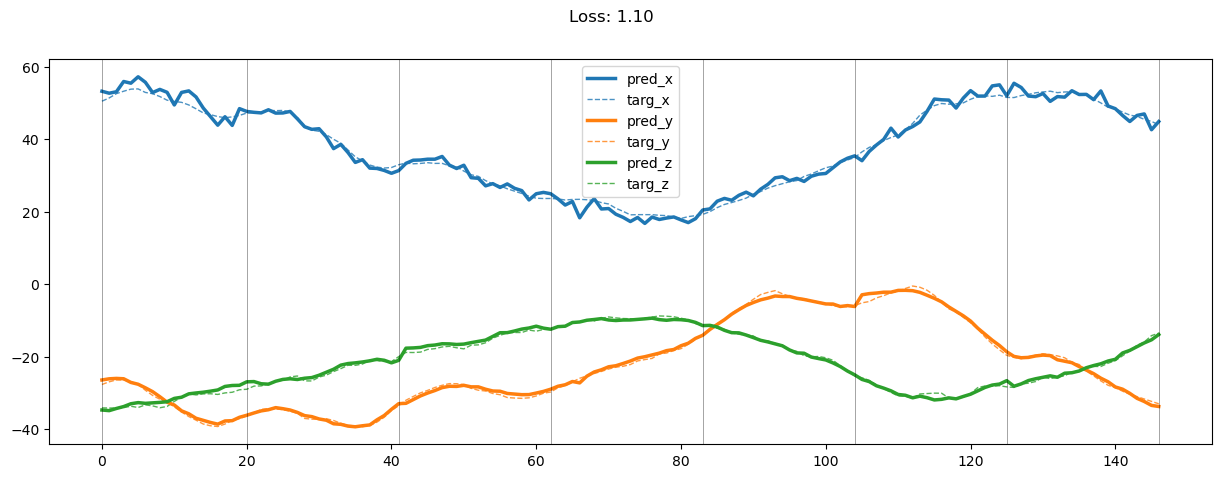

05199: train loss:  4.182, imu loss:  0.685, mag loss:  3.497
       valid loss:  208.330, imu loss:  0.509, mag loss:  207.822
05219: train loss:  4.095, imu loss:  0.684, mag loss:  3.410
       valid loss:  209.026, imu loss:  0.509, mag loss:  208.518
05239: train loss:  4.345, imu loss:  0.676, mag loss:  3.668
       valid loss:  206.591, imu loss:  0.509, mag loss:  206.082
05259: train loss:  4.149, imu loss:  0.678, mag loss:  3.471
       valid loss:  214.154, imu loss:  0.509, mag loss:  213.645
05279: train loss:  4.047, imu loss:  0.680, mag loss:  3.367
       valid loss:  212.837, imu loss:  0.509, mag loss:  212.328
05299: train loss:  4.217, imu loss:  0.671, mag loss:  3.546
       valid loss:  209.006, imu loss:  0.509, mag loss:  208.497
05319: train loss:  4.127, imu loss:  0.677, mag loss:  3.450
       valid loss:  210.259, imu loss:  0.509, mag loss:  209.750
05339: train loss:  4.126, imu loss:  0.673, mag loss:  3.453
       valid loss:  210.206, imu loss:  0.

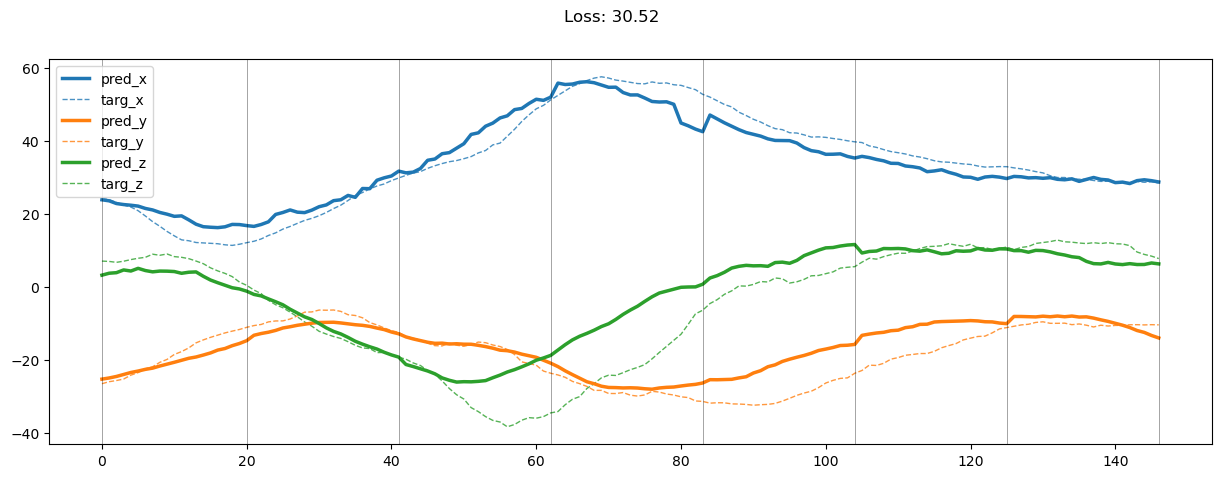

05399: train loss:  4.274, imu loss:  0.678, mag loss:  3.596
       valid loss:  213.412, imu loss:  0.509, mag loss:  212.903
05419: train loss:  4.067, imu loss:  0.680, mag loss:  3.387
       valid loss:  210.694, imu loss:  0.509, mag loss:  210.185
05439: train loss:  4.062, imu loss:  0.681, mag loss:  3.381
       valid loss:  211.288, imu loss:  0.509, mag loss:  210.780
05459: train loss:  3.969, imu loss:  0.674, mag loss:  3.295
       valid loss:  212.793, imu loss:  0.509, mag loss:  212.284
05479: train loss:  4.062, imu loss:  0.683, mag loss:  3.380
       valid loss:  206.507, imu loss:  0.509, mag loss:  205.999
05499: train loss:  3.993, imu loss:  0.669, mag loss:  3.323
       valid loss:  216.104, imu loss:  0.509, mag loss:  215.595
05519: train loss:  4.109, imu loss:  0.692, mag loss:  3.416
       valid loss:  211.057, imu loss:  0.509, mag loss:  210.548
05539: train loss:  4.146, imu loss:  0.677, mag loss:  3.469
       valid loss:  209.174, imu loss:  0.

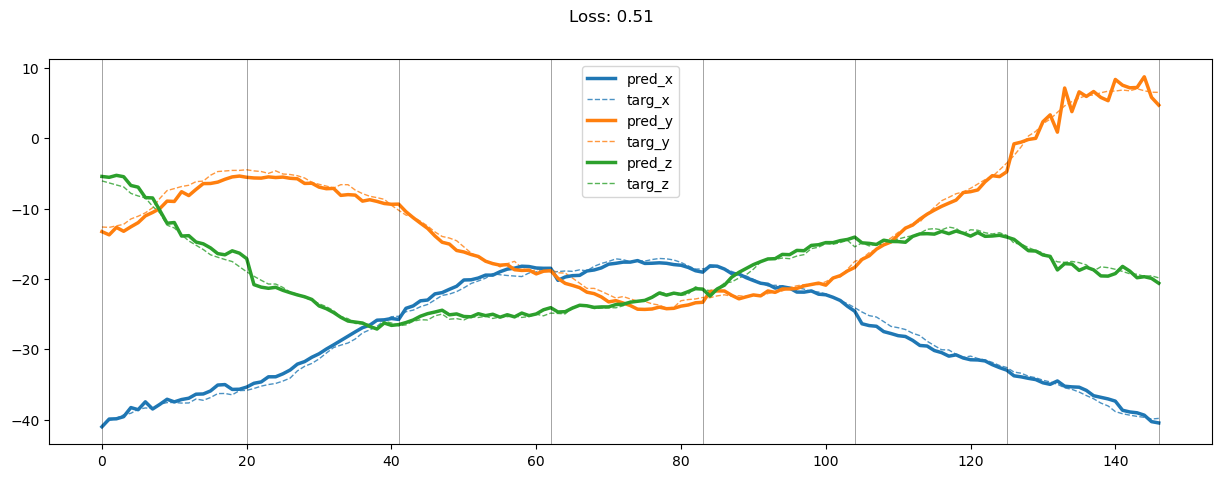

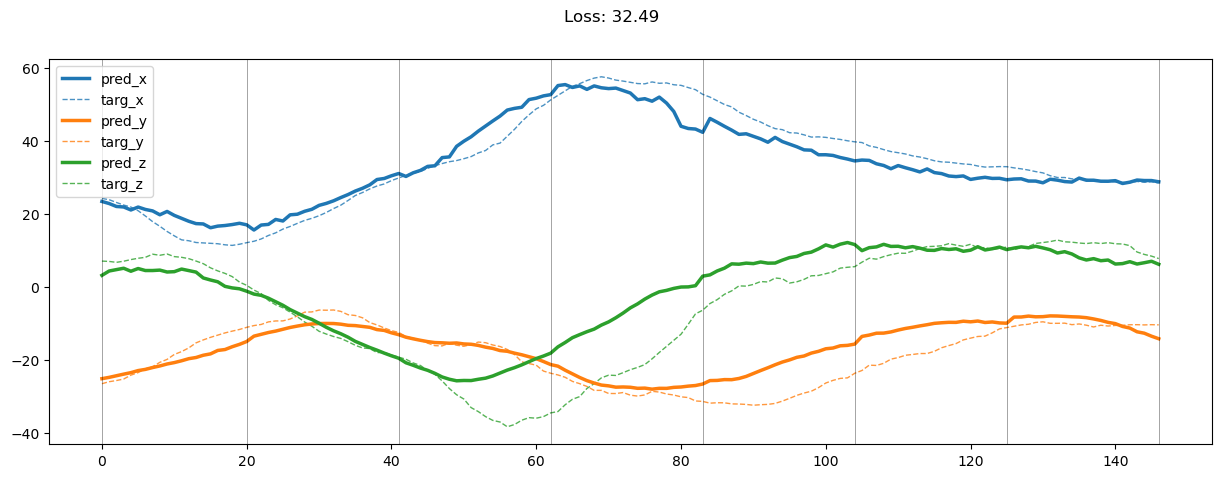

05599: train loss:  4.036, imu loss:  0.678, mag loss:  3.358
       valid loss:  211.735, imu loss:  0.509, mag loss:  211.226
05619: train loss:  3.885, imu loss:  0.681, mag loss:  3.204
       valid loss:  213.931, imu loss:  0.509, mag loss:  213.423
05639: train loss:  3.879, imu loss:  0.667, mag loss:  3.212
       valid loss:  211.034, imu loss:  0.509, mag loss:  210.526
05659: train loss:  4.100, imu loss:  0.674, mag loss:  3.426
       valid loss:  208.017, imu loss:  0.509, mag loss:  207.508
05679: train loss:  4.149, imu loss:  0.686, mag loss:  3.463
       valid loss:  209.648, imu loss:  0.509, mag loss:  209.139
05699: train loss:  3.954, imu loss:  0.680, mag loss:  3.274
       valid loss:  212.664, imu loss:  0.509, mag loss:  212.155
05719: train loss:  4.187, imu loss:  0.684, mag loss:  3.503
       valid loss:  218.755, imu loss:  0.509, mag loss:  218.246
05739: train loss:  3.879, imu loss:  0.674, mag loss:  3.205
       valid loss:  211.272, imu loss:  0.

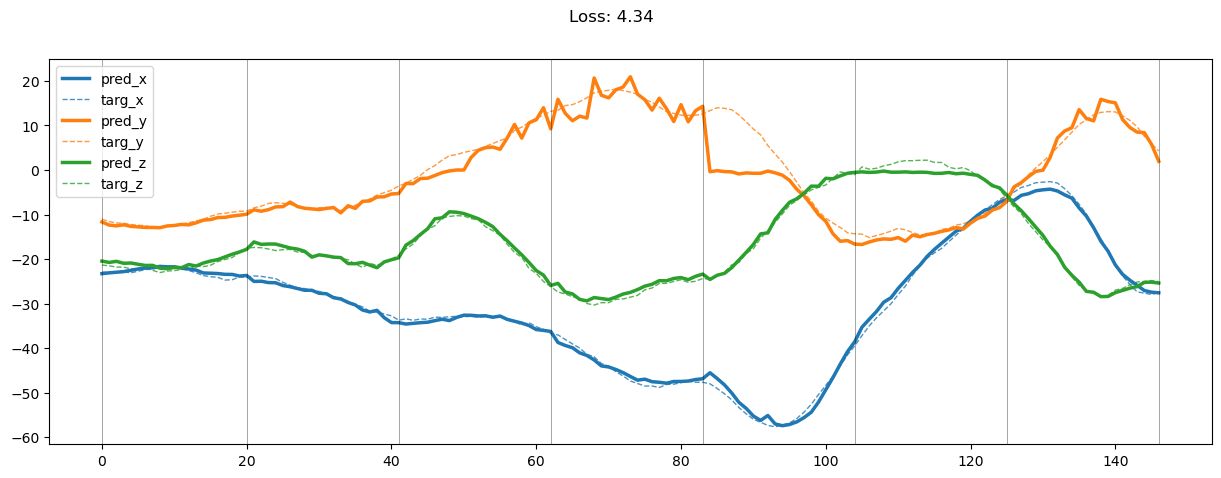

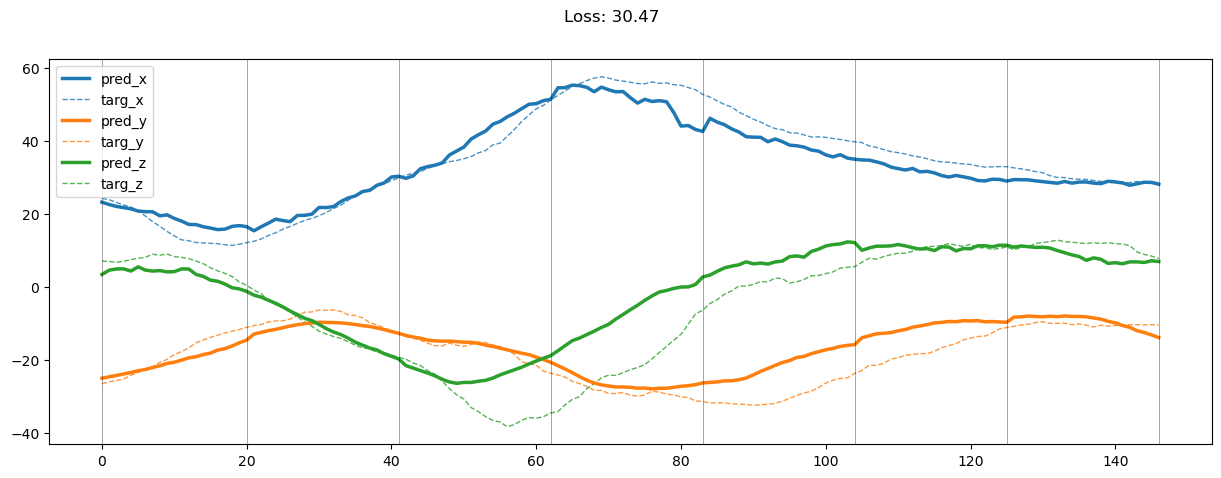

05799: train loss:  4.053, imu loss:  0.679, mag loss:  3.374
       valid loss:  217.371, imu loss:  0.509, mag loss:  216.863
05819: train loss:  4.002, imu loss:  0.679, mag loss:  3.323
       valid loss:  214.883, imu loss:  0.509, mag loss:  214.375
05839: train loss:  4.003, imu loss:  0.681, mag loss:  3.322
       valid loss:  215.496, imu loss:  0.509, mag loss:  214.987
05859: train loss:  3.984, imu loss:  0.678, mag loss:  3.307
       valid loss:  216.995, imu loss:  0.509, mag loss:  216.486
05879: train loss:  3.970, imu loss:  0.679, mag loss:  3.291
       valid loss:  210.446, imu loss:  0.509, mag loss:  209.938
05899: train loss:  3.855, imu loss:  0.679, mag loss:  3.176
       valid loss:  212.259, imu loss:  0.509, mag loss:  211.750
05919: train loss:  3.946, imu loss:  0.679, mag loss:  3.267
       valid loss:  212.730, imu loss:  0.509, mag loss:  212.222
05939: train loss:  3.886, imu loss:  0.683, mag loss:  3.203
       valid loss:  209.274, imu loss:  0.

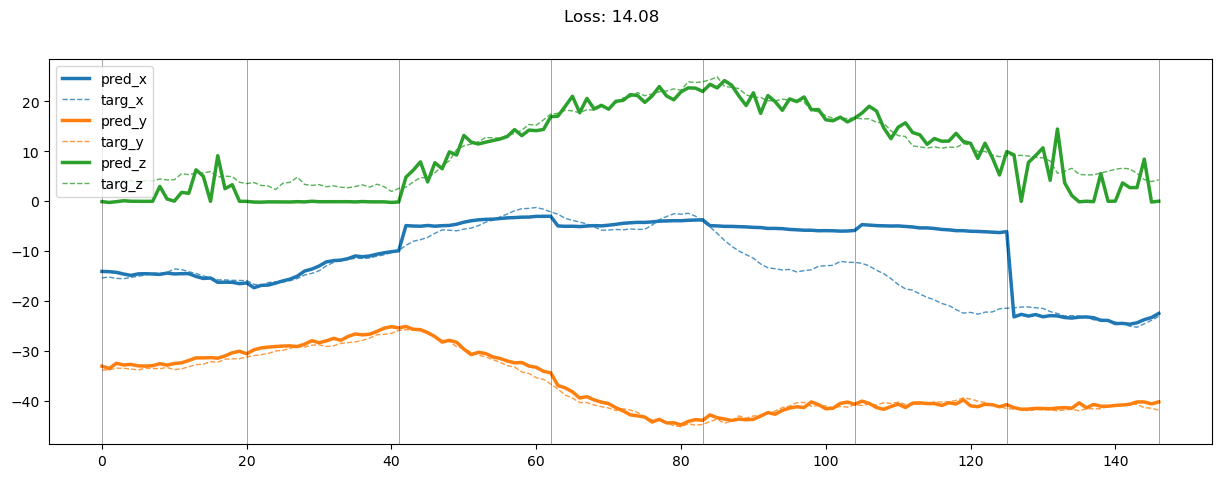

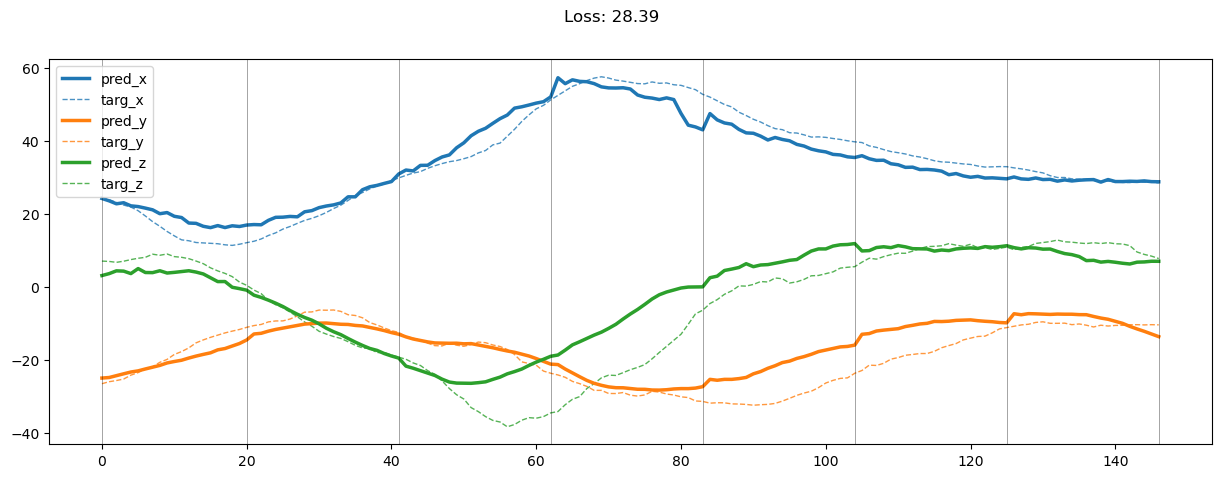

05999: train loss:  4.011, imu loss:  0.675, mag loss:  3.336
       valid loss:  211.752, imu loss:  0.509, mag loss:  211.243


In [49]:
draw = False

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 200 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 20 == 0:
        ep = str(epoch).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}')

In [203]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, :, :6]
            source_mag = source_data[:, :, :, 6:9]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, :, :6]
            target_mag = target_data[:, :, :, 6:9]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [209]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(897, 3) (897,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    10.19     1.10     1.19     4.16
         pocket loss:     2.48     0.93     0.71     1.38
          swing loss:     5.53     1.05     0.66     2.41
        average loss:     6.14     1.03     0.86     2.68


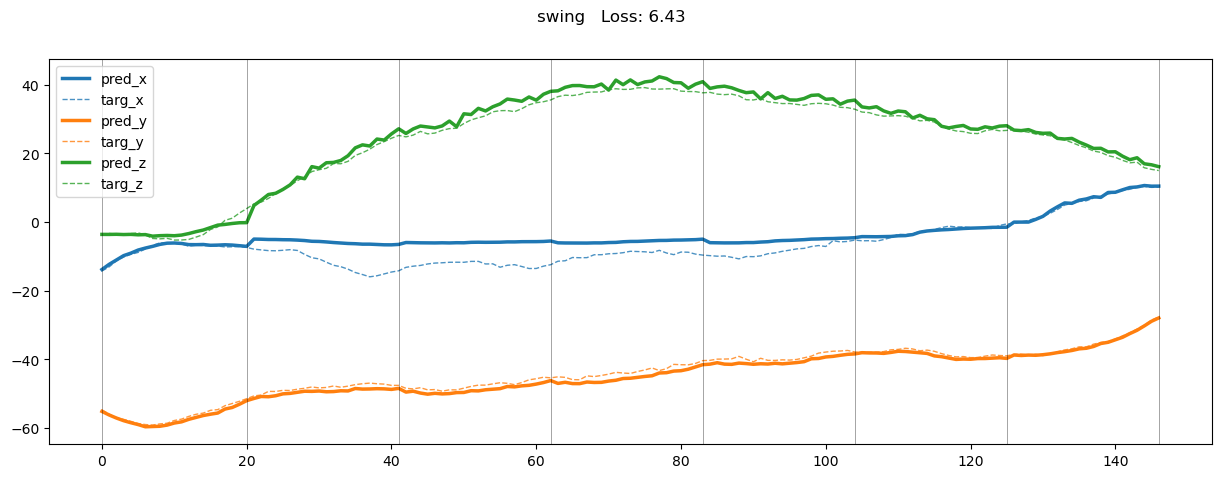

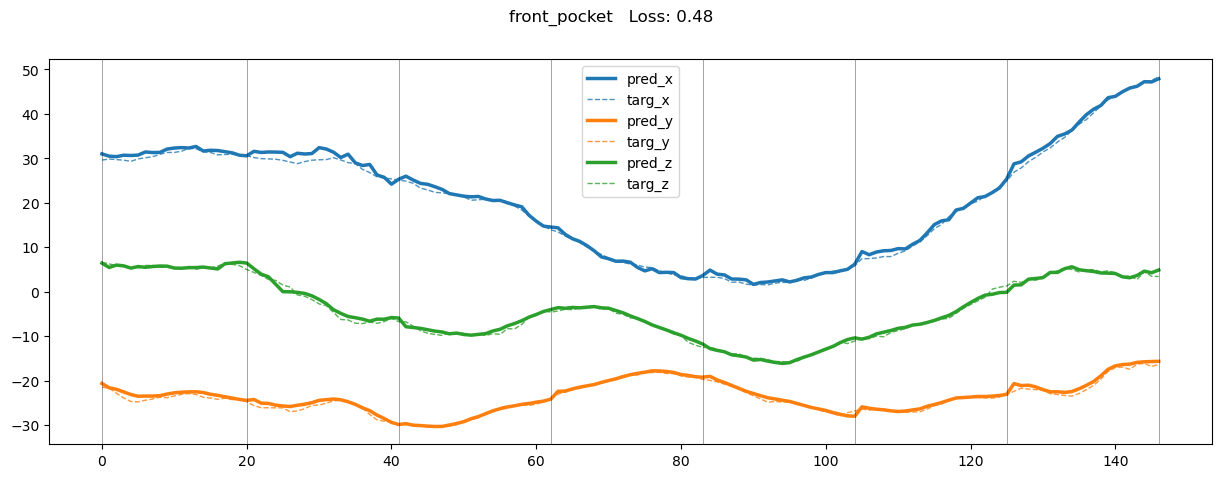

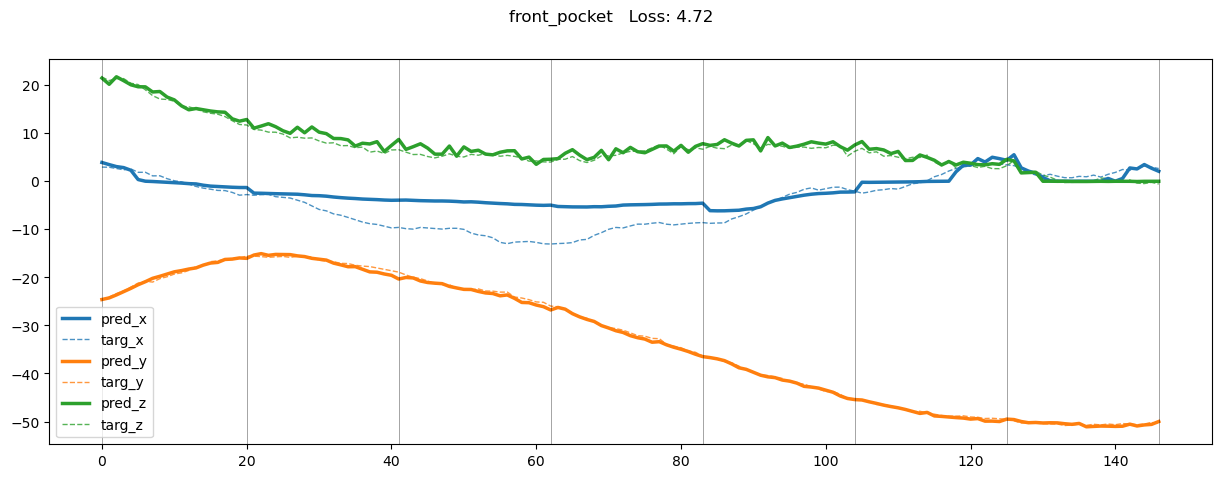

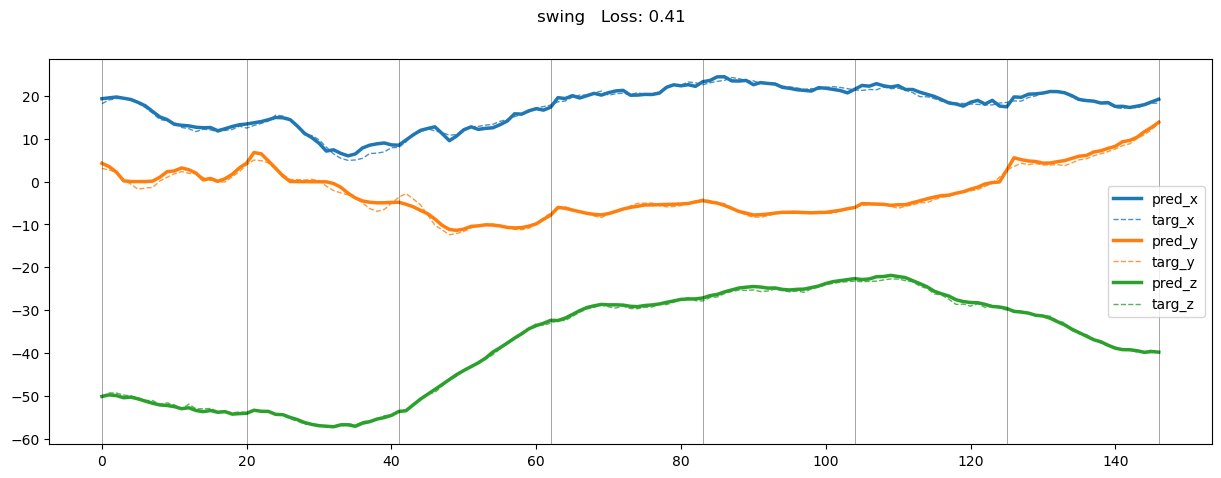

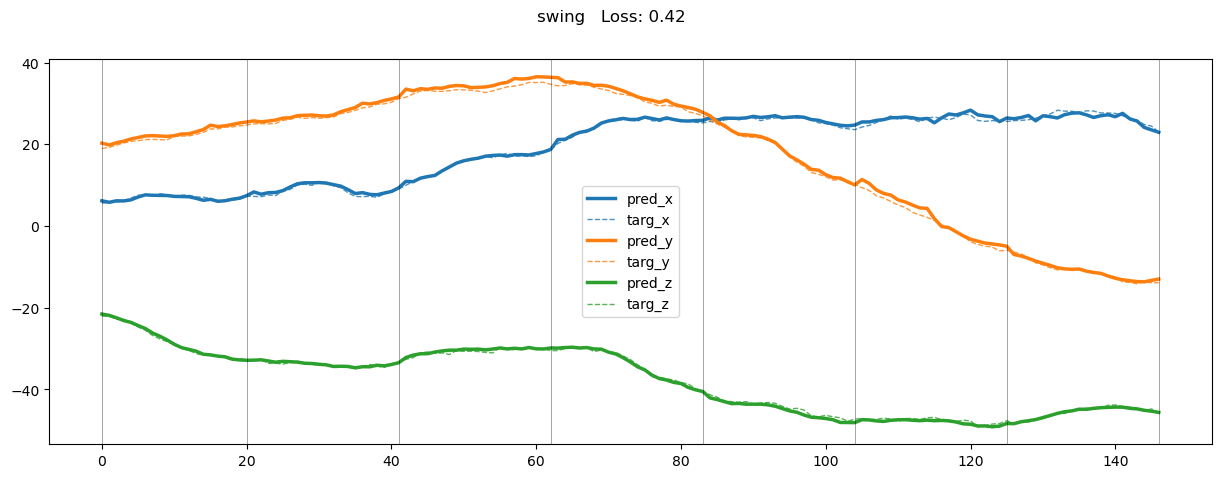

In [211]:
results, cres, clabel = output_eval(model, train_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::200]:
    plot_result(rs)

(225, 3) (225,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    82.89    68.77    36.07    62.58
         pocket loss:   654.90   417.09   148.30   406.76
          swing loss:   331.89   115.71    68.06   171.89
        average loss:   351.81   198.56    83.36   211.24


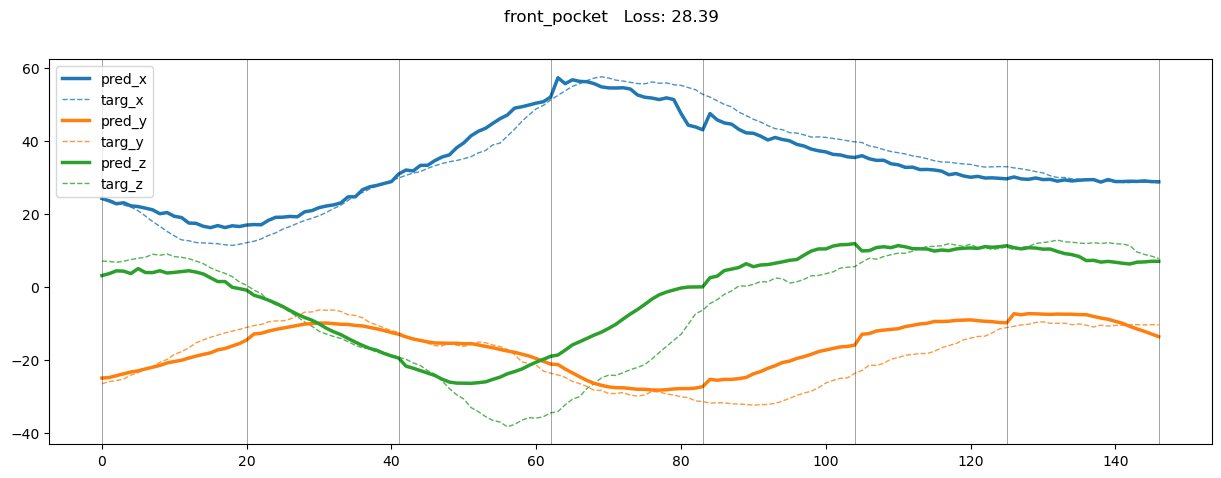

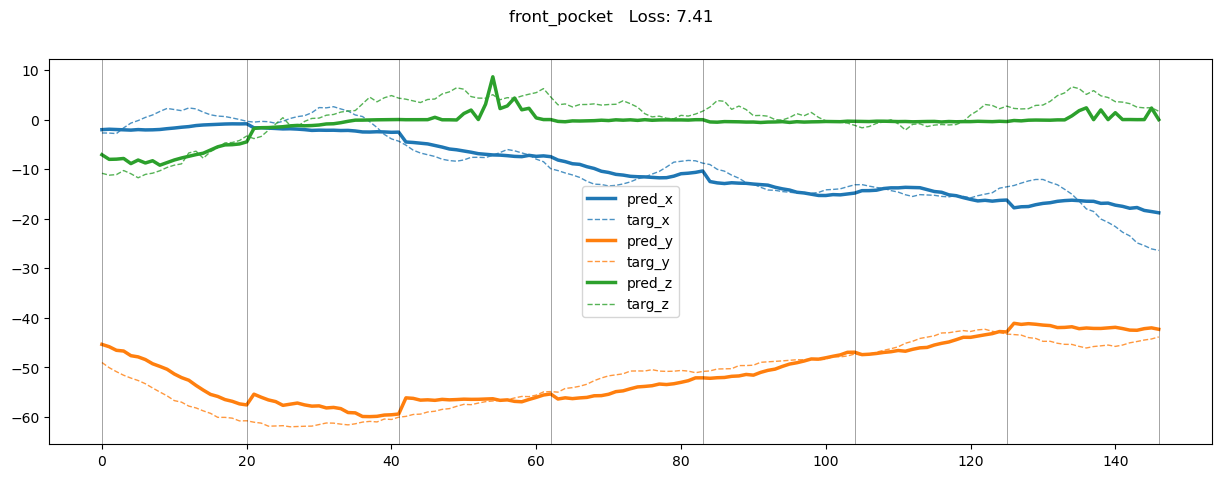

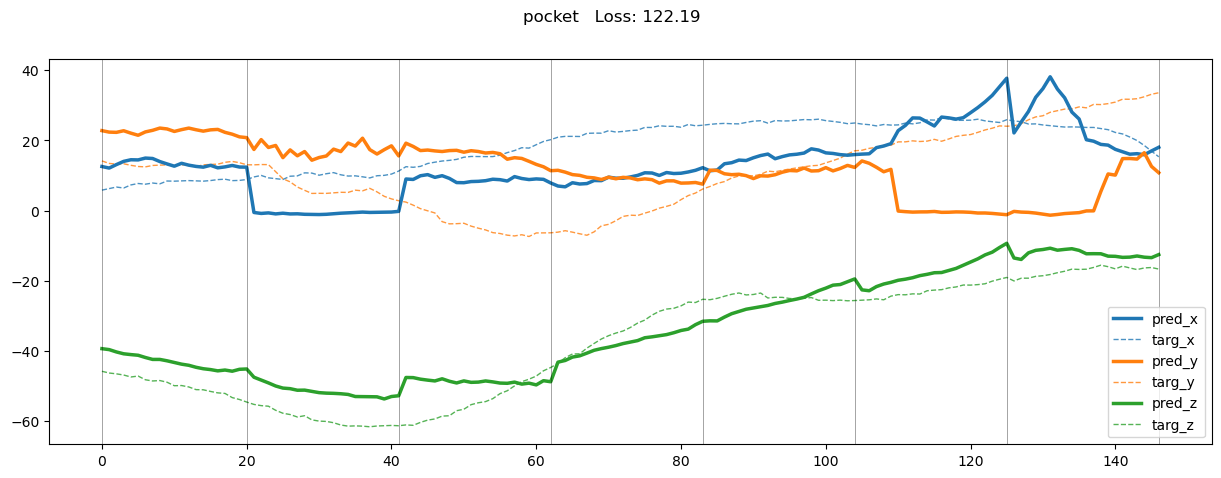

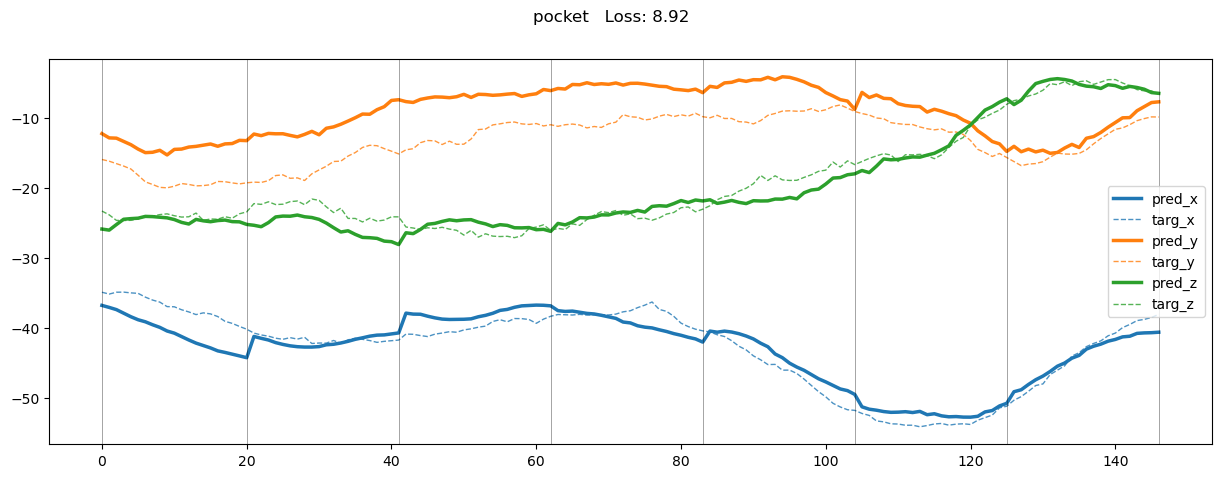

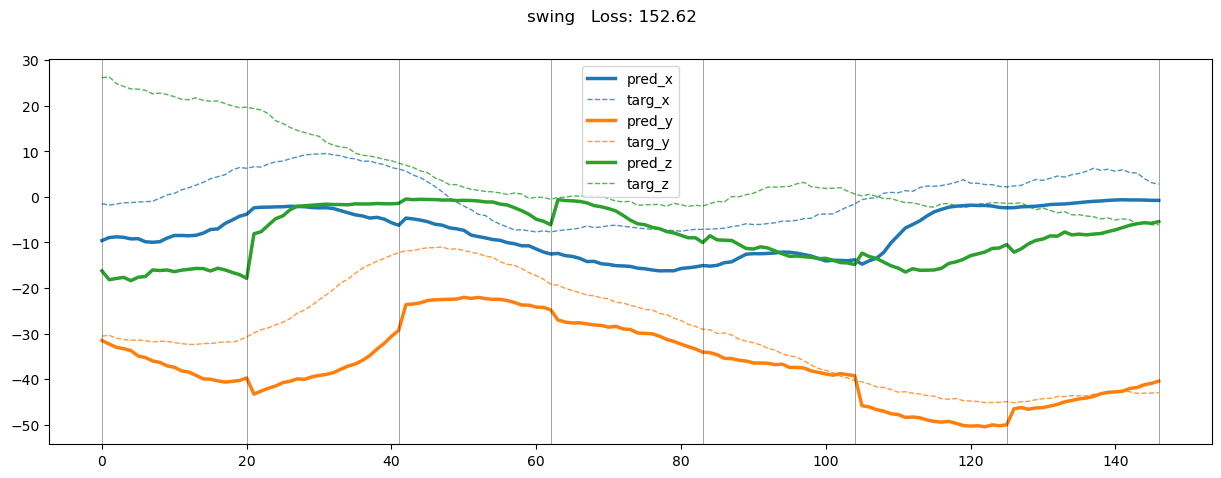

In [212]:
results, cres, clabel = output_eval(model, valid_loader)
print(cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::50]:
    plot_result(rs)